### Import relevant packages and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels
import datetime as dt
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import scipy.signal.spectral as signal
from statsmodels.tsa.stattools import periodogram

#-------------------------------------------------------------#
##################### Actvitity onset #########################
#-------------------------------------------------------------#

#-------------------------------------------------------------------
#    Find threshold crossings of the series of threshold of its own mean
#-------------------------------------------------------------------
def find_crossings(series):
    # Use mean activity for threshold crossig of activity
    threshold = series.rolling('3H').std()
    # Shift the series and calculate threshold crossing
    shifted = series.shift(-1)
    cross = ((series <= threshold) & (shifted > threshold))
    return(cross)

#-------------------------------------------------------------------
#    Find time (in minutes) for activity, given by variable **series** after the lights go off
#-------------------------------------------------------------------
def activity_onset (series, hour):
    hour = 20
    minute = 6
    cross = find_crossings(series)
    all_crossings = series.index[cross]
    # Keep only crossing which is after the lights goes off
    onset = series.index[cross].time >= dt.time(hour,minute)
    # Extract times and convert them in minutes
    time_after_dark = (all_crossings[onset].hour - hour)*60. + all_crossings[onset].minute
    #time_after_dark = all_crossings[onset].minute

    return(time_after_dark)


#-------------------------------------------------------#
##################### FRP + ACF #########################
#-------------------------------------------------------#

# find peak of the acf function
def acf_peak(df, spider):
    # we are only interested in FRP that are longer than 10 hours
    t_start = 10
    df_t = df[df.index > t_start]
    peak = df_t[spider].values.argmax()
    return([df_t.index[peak], df_t[spider].iloc[peak]])

# find the acf of a dataframe
def make_acf_df(df):
    # Make list of column names, that is spider IDs
    spiders = df.columns[1:]
    max_lag_hrs = 36
    # Make a dataframe for acf with time in hours as an index
    time = np.arange(0, max_lag_hrs*60+1)/60.
    acf_df = pd.DataFrame(columns = spiders, index= time)
    for x in spiders:
        acf_df[x]= statsmodels.tsa.stattools.acf(LD[x], nlags=max_lag_hrs*60, fft=True)
    return(acf_df)

#-------------------------------------------------#
##################### plot ########################
#-------------------------------------------------#

# plot activity of one day for one spider
# df is usually LD, spider is the spider number, day is what day pf activity we are interested in
def plotoneday(df, spider, day): 
    daylist = df.Date.unique()
    dataframe = df[df.Date == daylist[day-1]]

    plt.plot(dataframe.index, dataframe[spider])

    time = activity_onset(dataframe[spider], switch[day-1])
    # if the spider has a onset, convert it into minute and plot it as red star, if not return 'NaN' 
    if time.shape[0]>0:
        onset = pd.to_timedelta(pd.TimedeltaIndex(time, unit = 'm'))[0]
        a =   onset  + pd.to_datetime(switch)[day-1]
        plt.plot(a ,dataframe[spider][a], '*', color="red")
    
    else:
        onset = 'NaN'
    
    # ther first gray bar is from the begining to when the lights were first turned on
    plt.axvspan(dataframe.index[0], dataframe.index[dataframe.lights == 1][0], alpha = 0.5, color = 'gray')
    
    # the second gray bar is from the last data point when lights were on to the last datapoint 
    plt.axvspan(dataframe.index[dataframe.lights == 1][-1], dataframe.index[-1], alpha = 0.5, color = 'gray')
    
    plt.ylabel(day)
    plt.xlabel('Time')
    plt.show()
    return(onset)

# plot all of the activity of the spider, spider is 's1','s2',,,; filename is a str of name that we want to save it as
def plotonespider(spider, FileName):
    daylist = LD.Date.unique()
    plt.figure(figsize=(15, 10))

    # loop through each day (in daylist)
    for i in range (1, len(daylist)):
        plt.subplot(len(daylist)-1, 1, i)
        df = LD[LD.Date == daylist[i]]
        
        plt.plot(df.index, df[spider])
        time = activity_onset(df[spider], switch[i])
        
        # if the spider has a onset, convert it into minute and plot it as red star, if not return 'NaN' 
        if time.shape[0]>0:
            onset = pd.to_timedelta(pd.TimedeltaIndex(time, unit = 'm'))[0]
            a =   onset  + pd.to_datetime(switch)[i]
            plt.plot(a ,df[spider][a], '*', color="red")
    
        else:
            onset = 'NaN'
    
        # ther first gray bar is from the begining to when the lights were first turned on
        plt.axvspan(df.index[0], df.index[df.lights == 1][0], alpha = 0.5, color = 'gray')
    
        # the second gray bar is from the last data point when lights were on to the last datapoint 
        plt.axvspan(df.index[df.lights == 1][-1], df.index[-1], alpha = 0.5, color = 'gray')
    
    plt.tight_layout()
    plt.savefig(FileName)
    return plt.show()

# calculat the onset for a spider, df is normally LD, spider is str of spider, day is a number (day 1's day is 1)
def oneday(df, spider, day): 
    daylist = df.Date.unique()
    dataframe = df[df.Date == daylist[day-1]]

    time = activity_onset(dataframe[spider], switch[day-1])
    # if the spider has a onset, convert it into minute, if not return 'NaN' 
    if time.shape[0]>0:
        onset = pd.to_timedelta(pd.TimedeltaIndex(time, unit = 'm'))[0]
      
    else:
        onset = 'NaN'
    return(onset)
# calculate the avverage of onset for a spider, loop through each day and use function oneday to find each onset and take the average
def onespider(spider):
    a = []
    for i in range (1, len(daylist)):
        eachday = oneday(LD, spider , i)
        # sometimes the spider does not have activity in a day, then there would be no onset
        # if the onset is not a number(aka is a str)then keep string, if a number, then calculate the average and append to list 
        if type(eachday) == str:
            onsetmin= float('NaN')
            a.append(onsetmin) 
        else:
            onsetmin = eachday.total_seconds()/60
            a.append(onsetmin) 
    
    meanonset = np.nanmean(a)
    return meanonset

#---------------------------------------------------------------------------#
##################### Plot lombsscargle periodogram #########################
#---------------------------------------------------------------------------#

# plot rastor plot on left, LS in middle, acf on right
one_day=24*60


# find period using periodogram peak
def findperiod(df, spider):
    #Define the array of frequencies for which to compute the periodogram:
    freq = np.arange(10,35,0.1)
    
    #calculate periodogram 
    pgram = signal.lombscargle(df.index, df[spider], freq, normalize = True)
    
    # power is the peak of the periodogram (y axis) period is the x axis value where peak is 
    power = np.max(pgram)
    period = freq[np.argmax(pgram)]
    
    return power, period

## Finding period using periodogram

/Users/luyang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


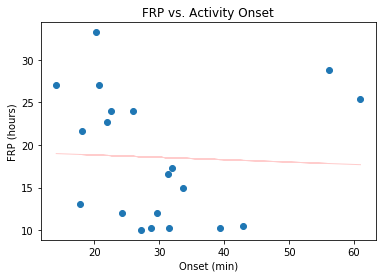

(-0.04507681473171084, 0.8503243261397039)
FRP = -0.0277 * Onset + 19.3887


In [19]:
def findperiod(df,spider):
    pgram = periodogram(df[spider].rolling('0.5H').mean())
    
    # create dataframe with power and period to we can plot and find max later
    LS = pd.DataFrame(index = range(len(pgram)))
    LS['Power'] = pgram
    
    #calculate period suign frequency.index
    LS['Period'] = len(pgram)/LS.index /60
    
    #keep only period between 10 and 35
    LS = LS[(LS.Period > 10) & (LS.Period < 35)]
    
    #find period and power 
    power = np.max(LS.Power)
    period = LS.Period[LS.Power == np.max(LS.Power)].iloc[0]
    
    return period, power

# plot raster plot on the left and acf on the right to confirm detection of period
def Plot_pgram(RasterData,Spider, filename):
    
    #Define the size of the figure
    plt.figure(figsize=(18,5))
    
    pgram = periodogram(RasterData[spider].rolling('0.5H').mean())
    
    # create dataframe with power and period to we can plot and find max later
    LS = pd.DataFrame(index = range(len(pgram)))
    LS['Power'] = pgram
    
    #calculate period using frequency.index
    LS['Period'] = len(pgram)/LS.index /60
    
     #keep only period between 10 and 35
    LS = LS[(LS.Period > 10) & (LS.Period < 35)]
    
    # plot periodogram and only the part of interest
    ax1 = plt.subplot(1,2,1)
    ax1.plot(LS.Period, LS.Power)
    #plt.xlim(10,35)
  
    period = LS.Period[LS.Power == np.max(LS.Power)].iloc[0]
    
    plt.xlabel('Period')
    plt.ylabel('Periodogram Power')
    plt.title('Period = ' + str(period))
    
    #Plotting the ACF Plot in the right panel
    #The total length of the lags, the number of lags, the number of ticks on the x-axis and the length between each tick
    hours=36
    lag=hours*60
    tick_count=6
    len_between_ticks=lag/tick_count
    
    #Plot the ACF
    ax2=plt.subplot(1,2,2)
    plot_acf(RasterData[Spider].rolling('2H').mean(),lags=lag,ax=ax2)
    
    #Change the unit of the x-axis into hours
    x=range(0,int(lag)+1,int(len_between_ticks))
    ax2.set_xticks(x)
    labels=[]
    for i in range(0,hours+1,tick_count):
        labels.append(str(i))
    ax2.set_xticklabels(labels)
    
    #Adjust the layout of the plots to avoid overlapping 
    plt.tight_layout()
    plt.savefig(filename)
    
    return plt.show()

#----------------------------------------------------------------------------------------------------------#
##################### Data frame(input LD and DD dateframe and set datetime index) #########################
#----------------------------------------------------------------------------------------------------------#
LD = pd.read_csv('LD.csv', header = 0, index_col = 0)
LD.index = pd.to_datetime(LD.index)
DD = pd.read_csv('DD.csv', header = 0, index_col = 0)
DD.index = pd.to_datetime(DD.index)

# turn date column into a list called daylist to be used for the for loops later on
daylist = LD.Date.unique()

# first find the index at which time swtiches 
switch = LD.index[LD.lights.diff()<0]
switchindex = LD.index.get_loc(switch[0])
start = switchindex
#--------------------------------------------------------------------#
##################### find Period using pgram #########################
#---------------------------------------------------------------------#
alive = LD.columns[3:].tolist()
LD_Per = pd.DataFrame(columns = ['Period', 'Power'], index = alive)

# find period of all live spdiders to see if they are entrained 
for spider in alive:
    [period, power] = findperiod(LD, spider)
    LD_Per.loc[spider] = [period, power]


# keep only the ones with period = 24
entrained = LD_Per[LD_Per.Period == 24]
entrained

#Loop throuhg the entrained spiders to find the FRP for those
FRP = pd.DataFrame(columns = ['Period', 'Power'], index = entrained.index )
for spider in entrained.index:
    [period, power] = findperiod(DD, spider)
    FRP.loc[spider] = [period, power]


#-------------------------------------------------------------------#
##################### Detect activity onset #########################
#-------------------------------------------------------------------#
# Add the onset data
FRP['Onset']  = 0
for spider in FRP.index:
    FRP['Onset'].loc[spider] = onespider(spider)

    
#----------------------------------------------------------------------------------------#
##################### correlation between activity onset and FRP #########################
#----------------------------------------------------------------------------------------#
#plot linear regression
# calculate linear regression
regressor = LinearRegression()  
X = FRP.Onset.values.reshape(-1,1)
Y = FRP.Period.values.reshape(-1,1)
regressor.fit(X, Y)
Y_pred = regressor.predict(X)

#plot figure (scatter) and the regression line
plt.figure(figsize = (6,4))
plt.scatter(FRP.Onset, FRP.Period)
plt.plot(X, Y_pred, color = 'red', alpha = 0.2, linewidth=1)

plt.title('FRP vs. Activity Onset')
plt.xlabel('Onset (min)')
plt.ylabel('FRP (hours)')
plt.savefig('FRP vs. Onset.png')

plt.show()

# print summary of results the first value is correlation coefficient, the second is pvalue
print(pearsonr(FRP.Onset, FRP.Period))

print('FRP = ' + str(regressor.coef_)[2:9] + ' * Onset + ' + str(regressor.intercept_)[1:8])



### Onset Rastor plots for visual inspection

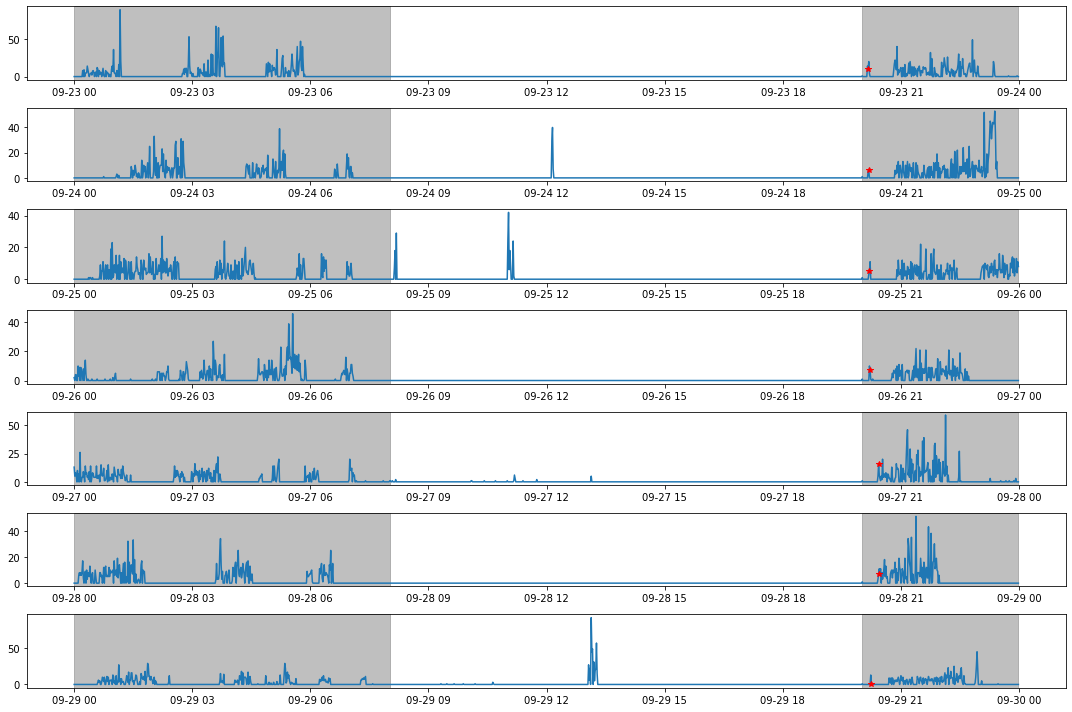

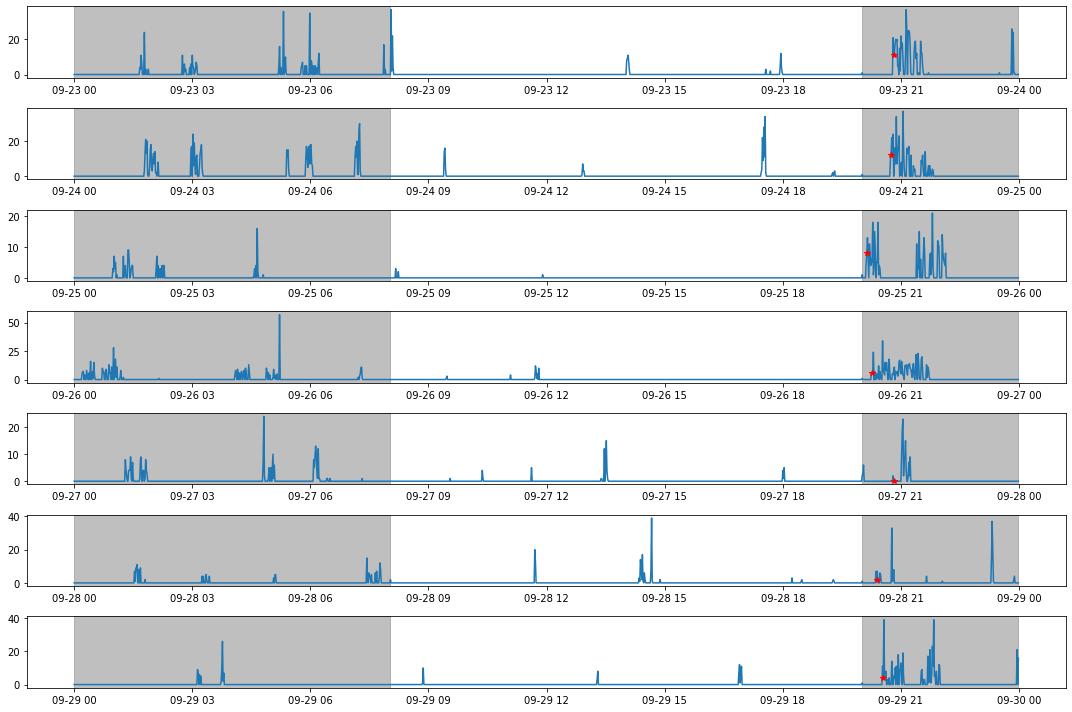

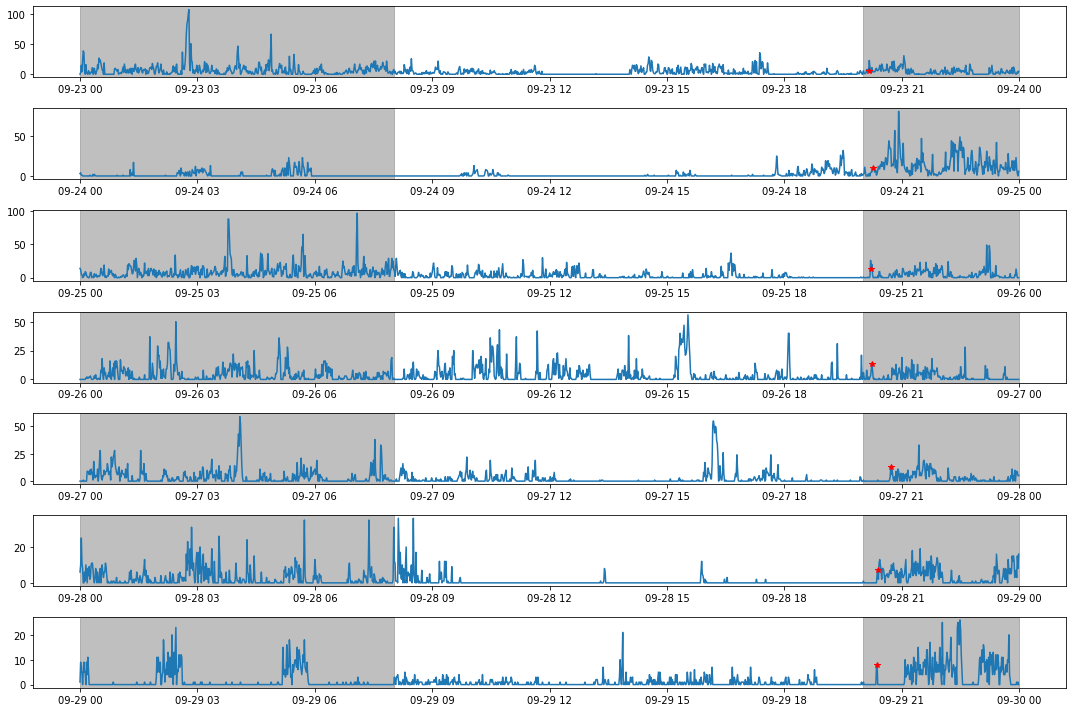

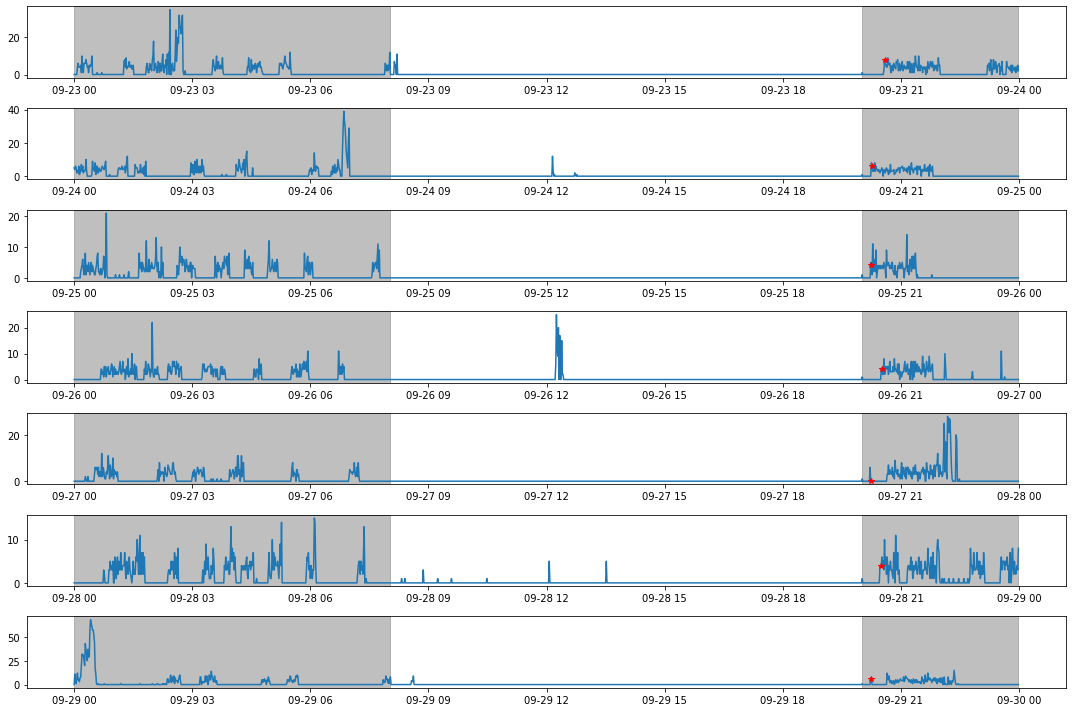

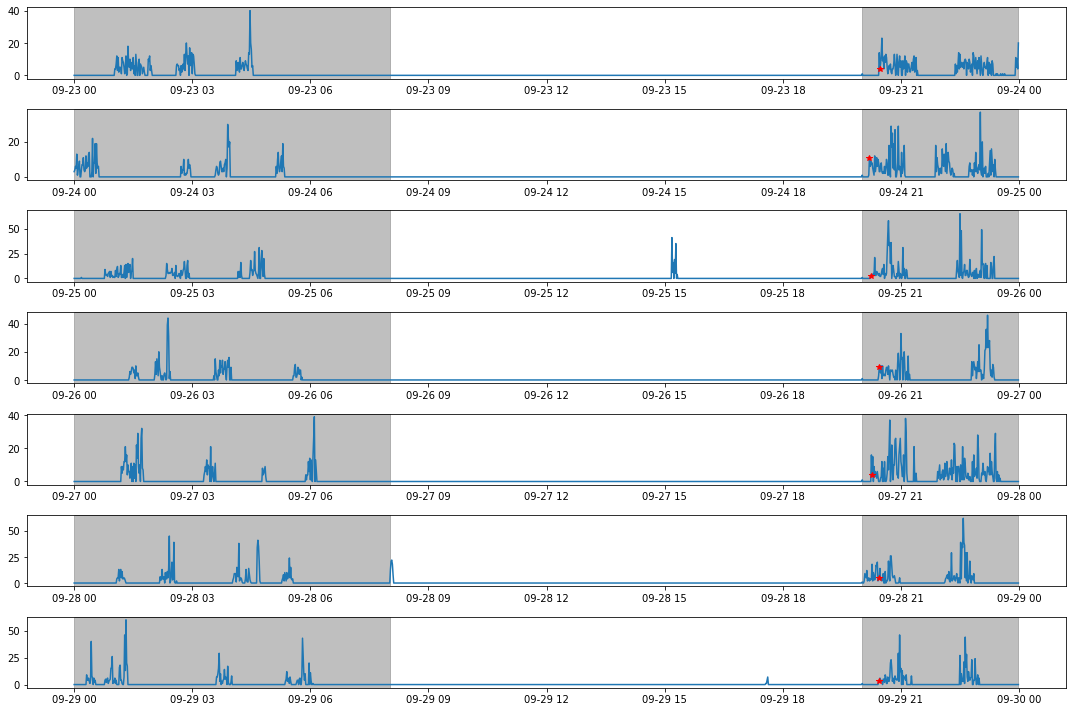

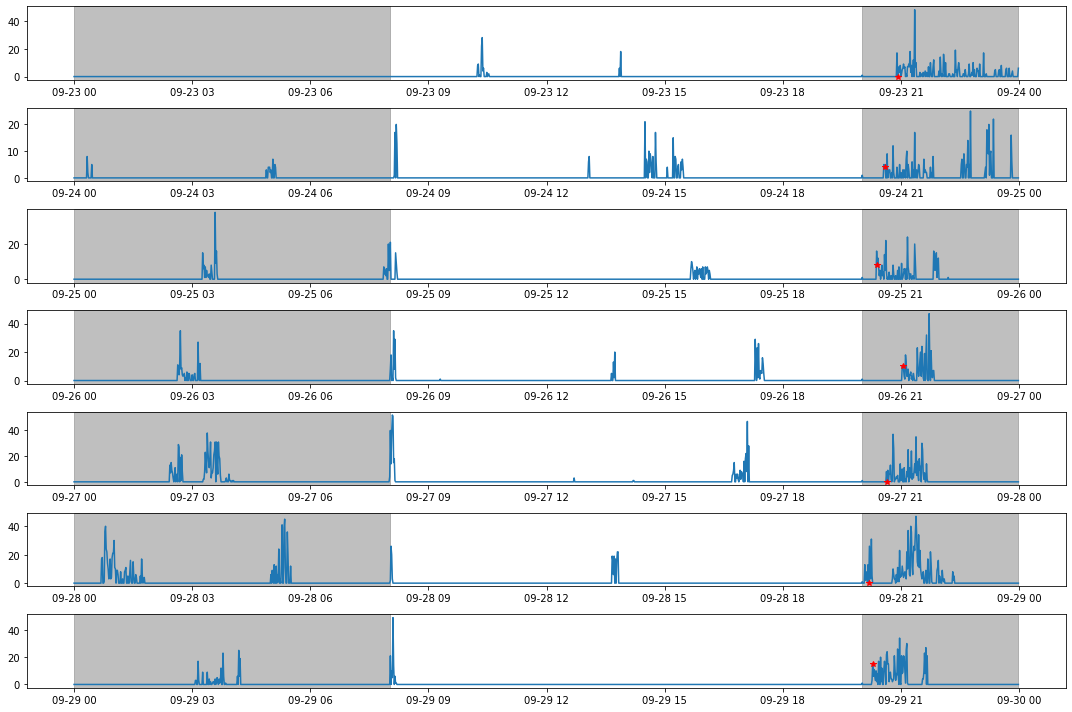

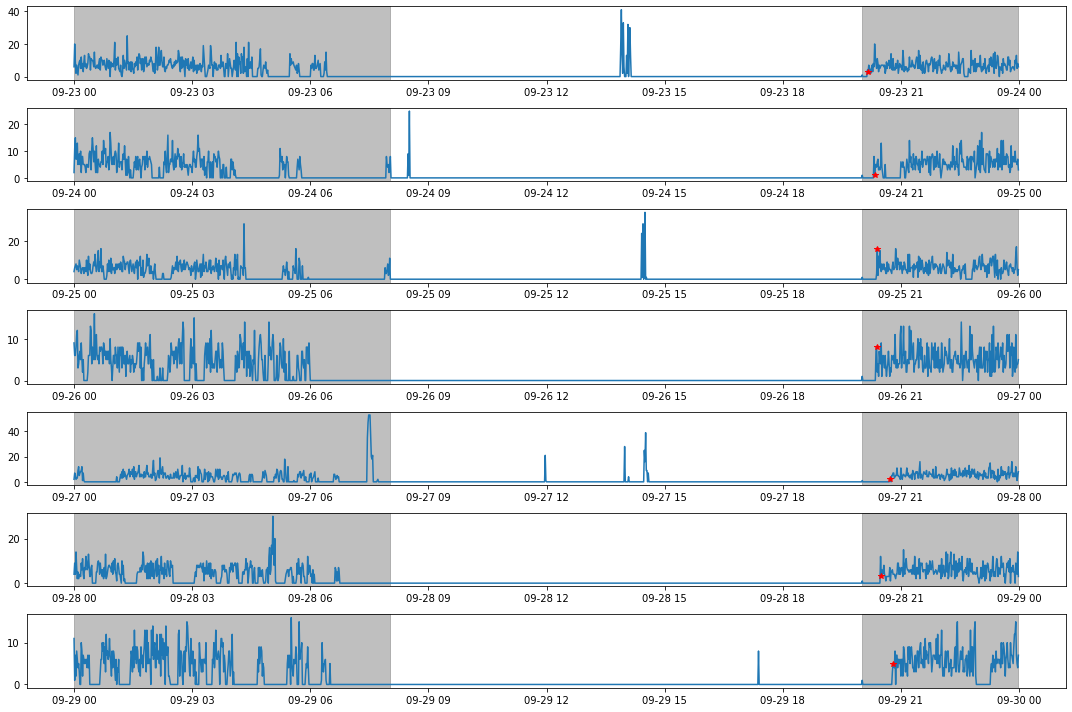

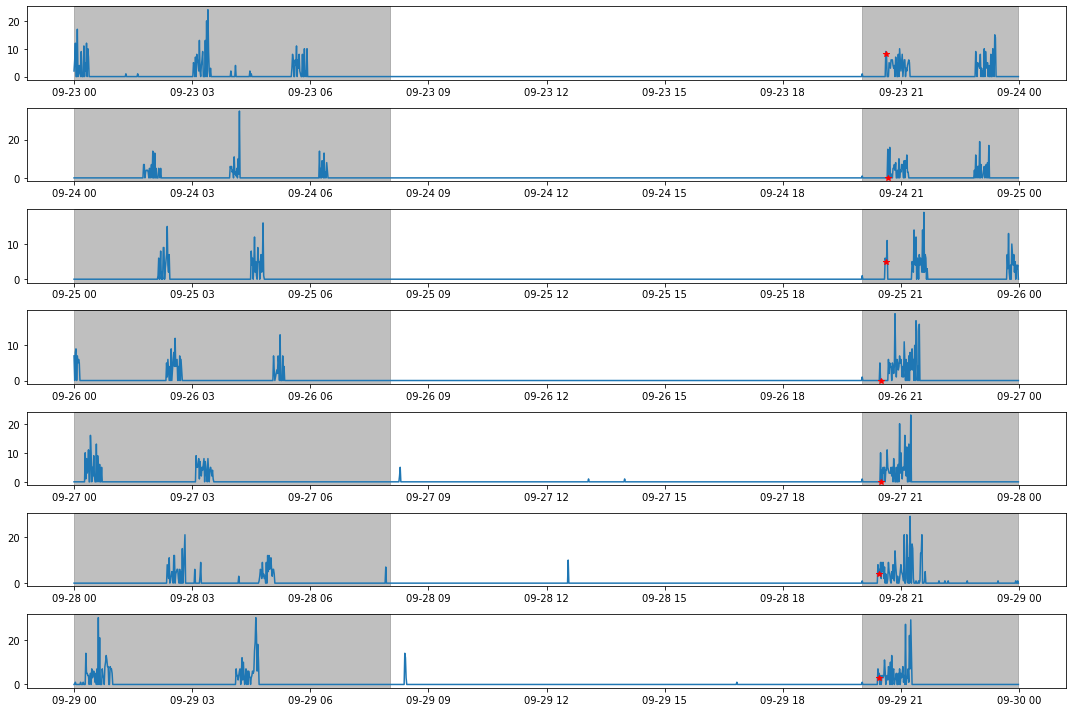

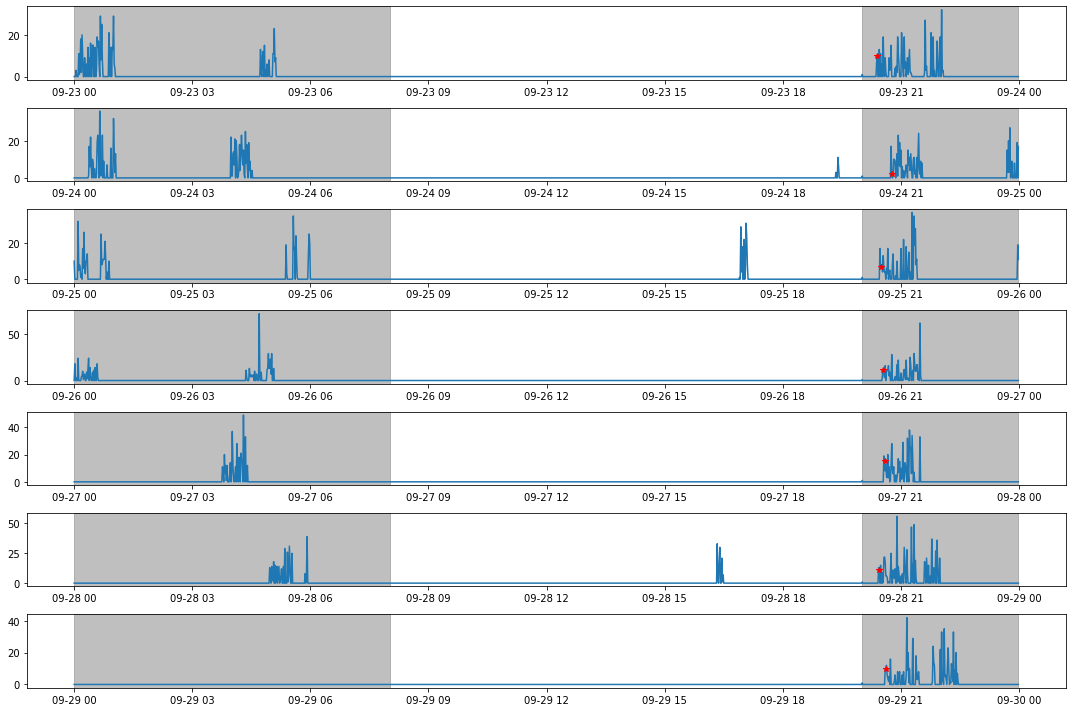

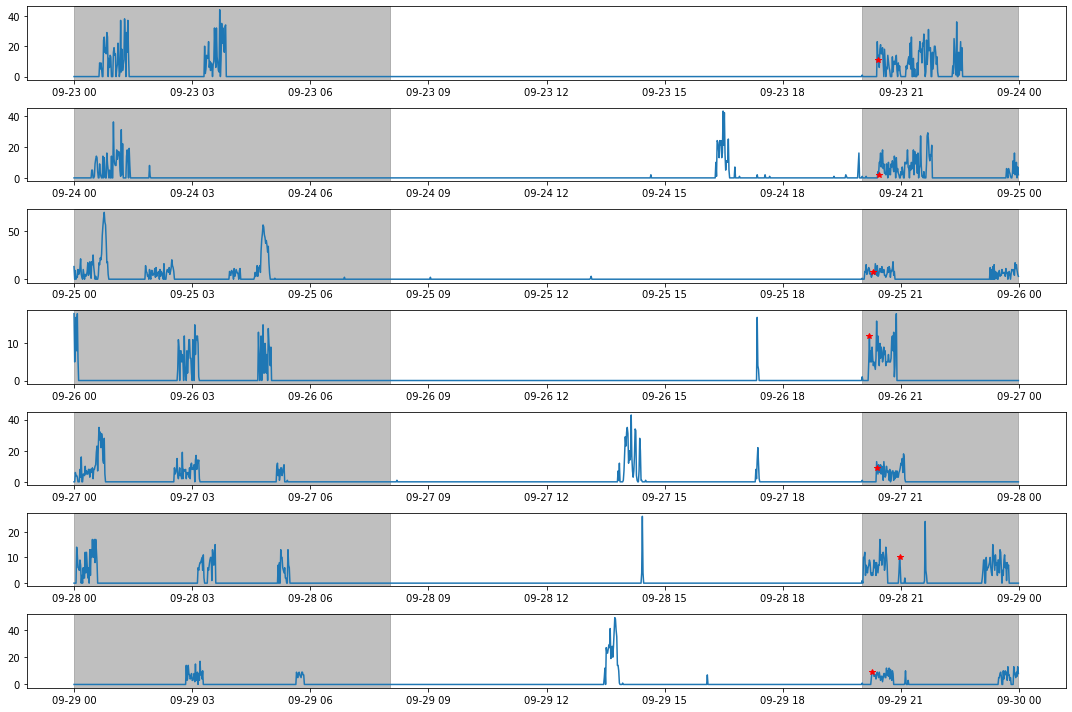

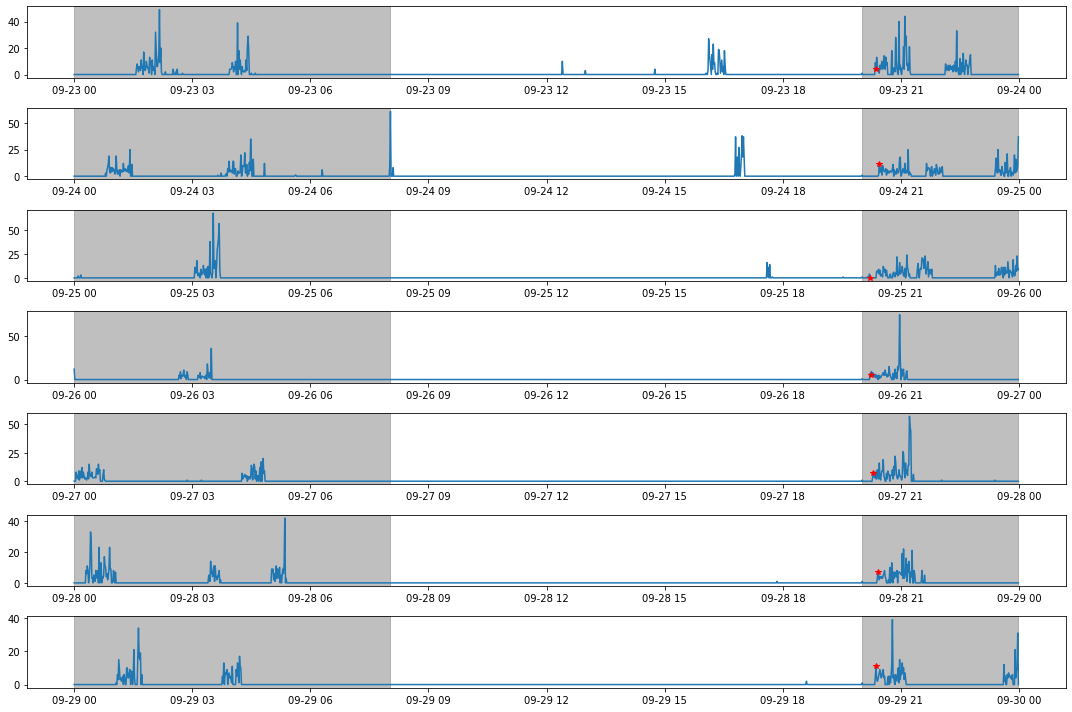

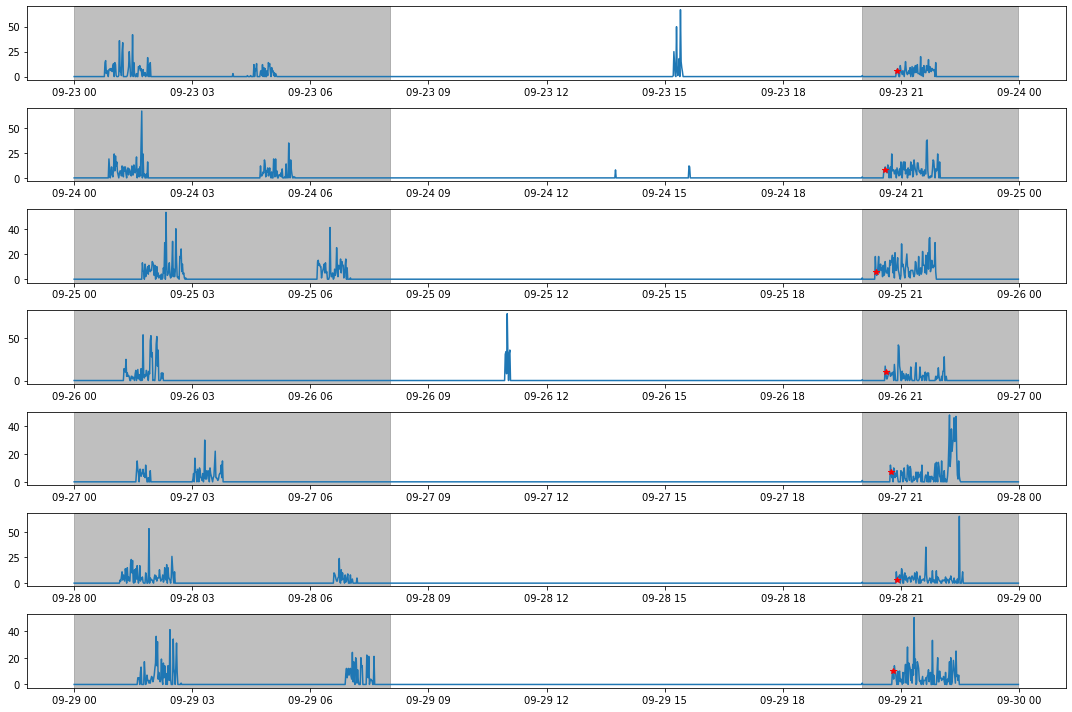

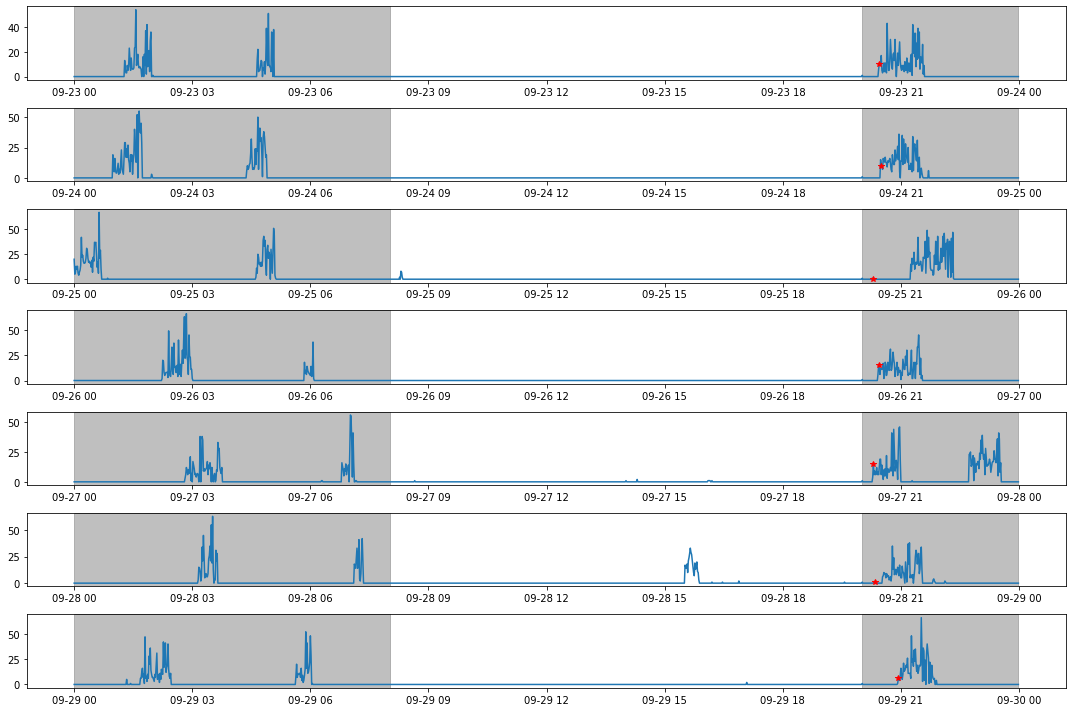

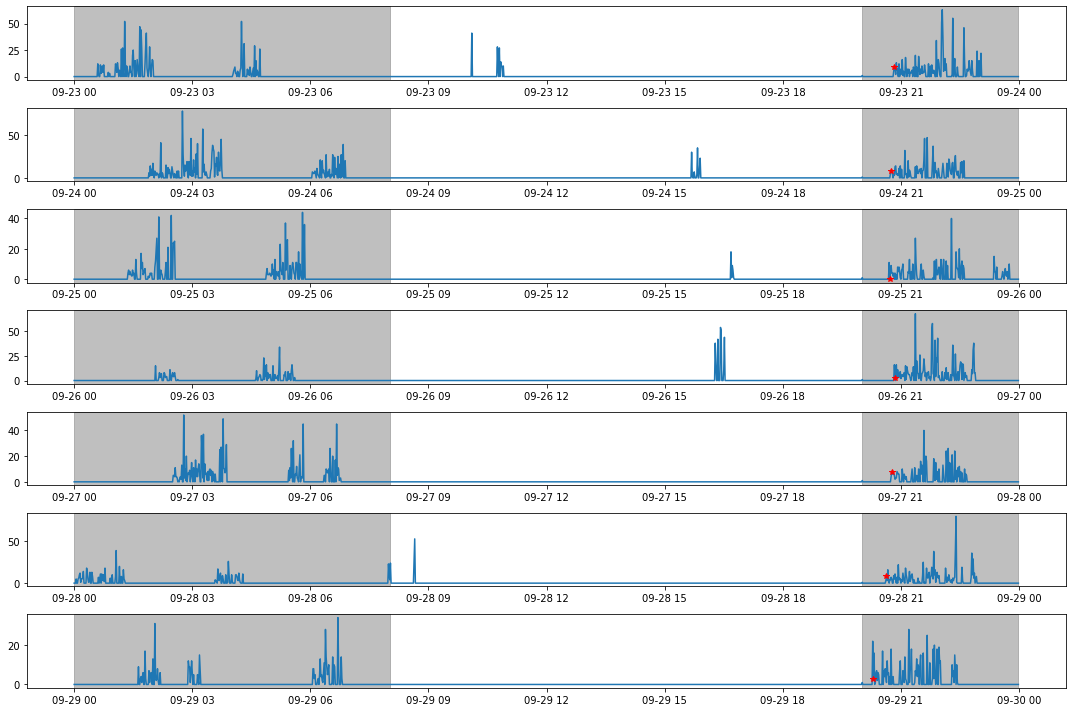

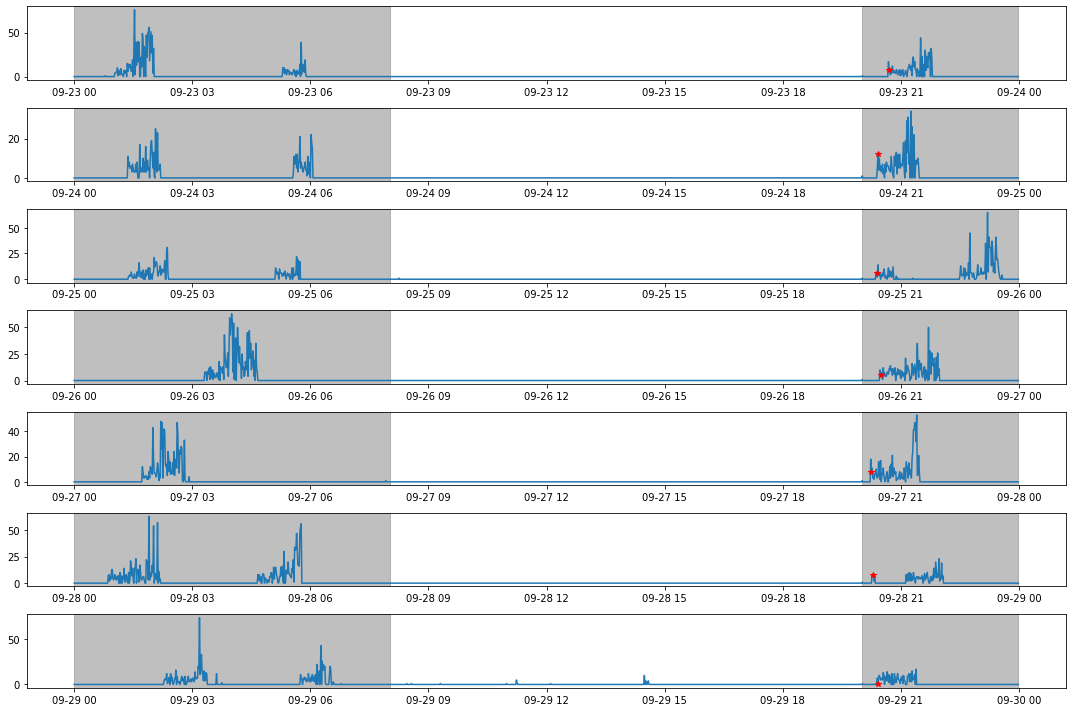

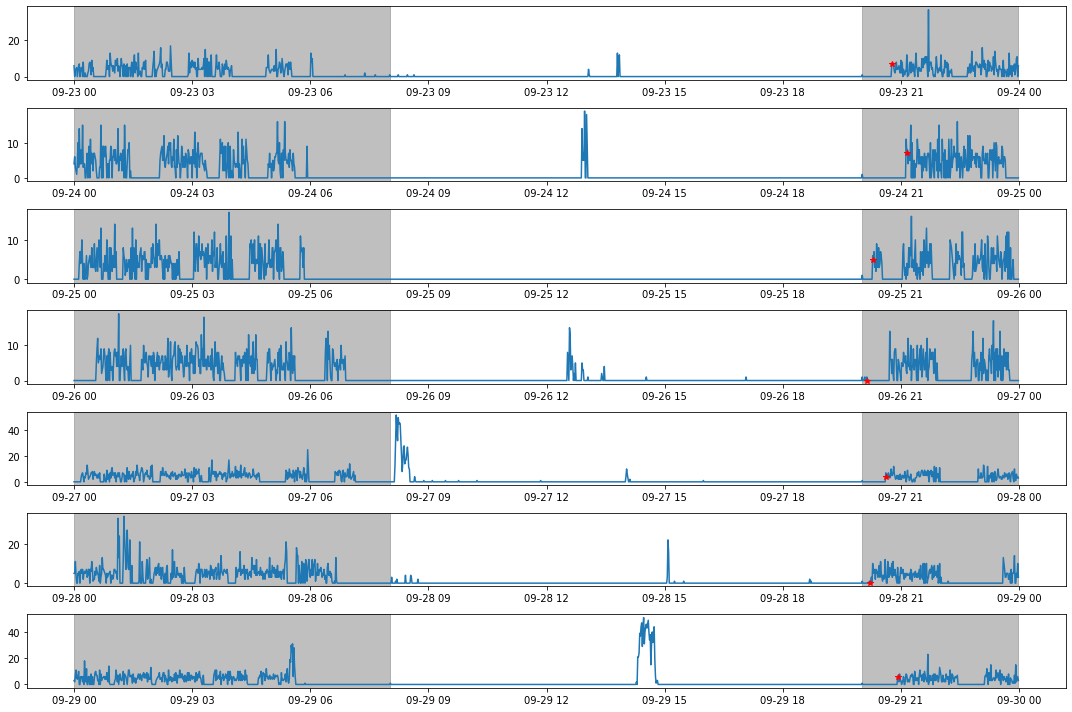

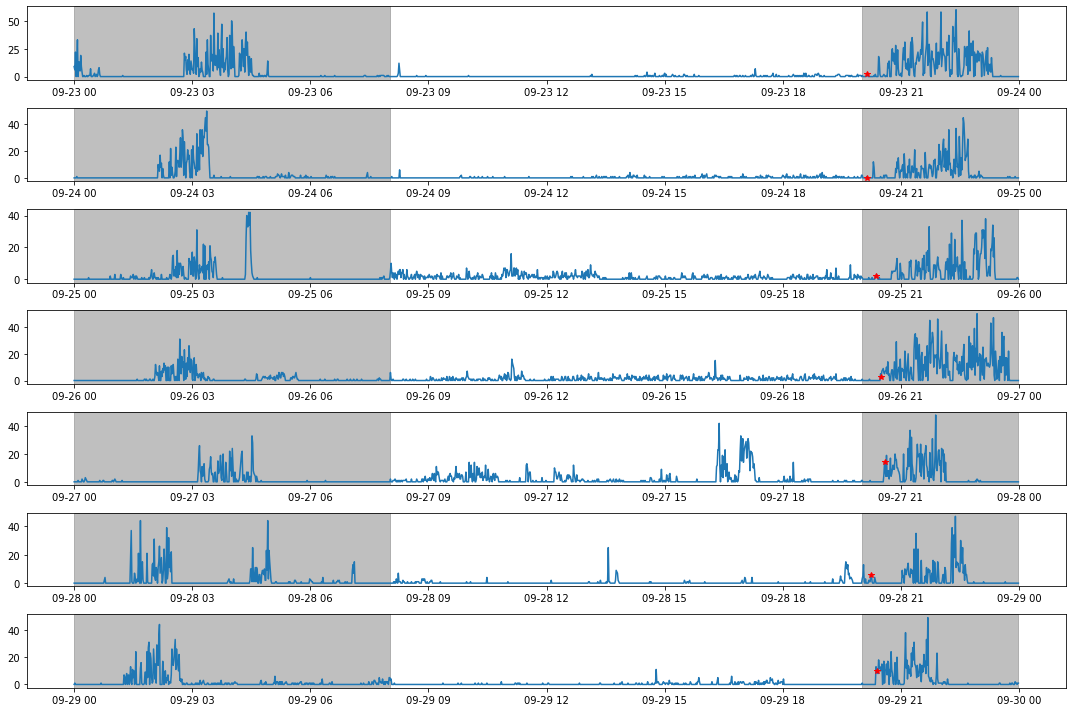

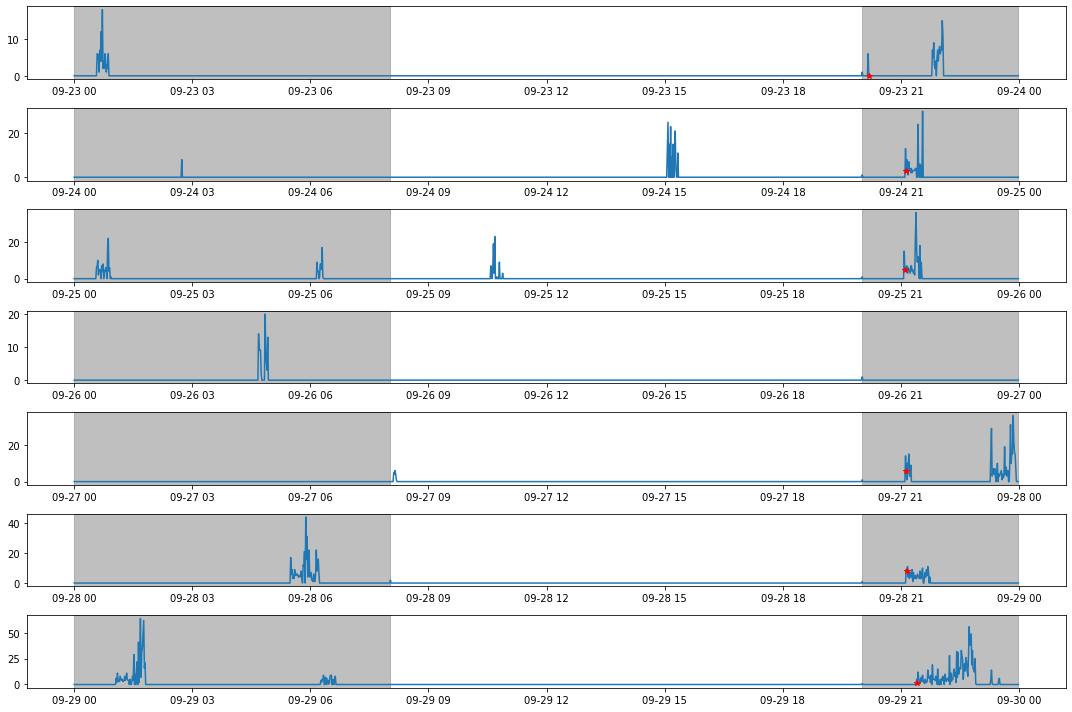

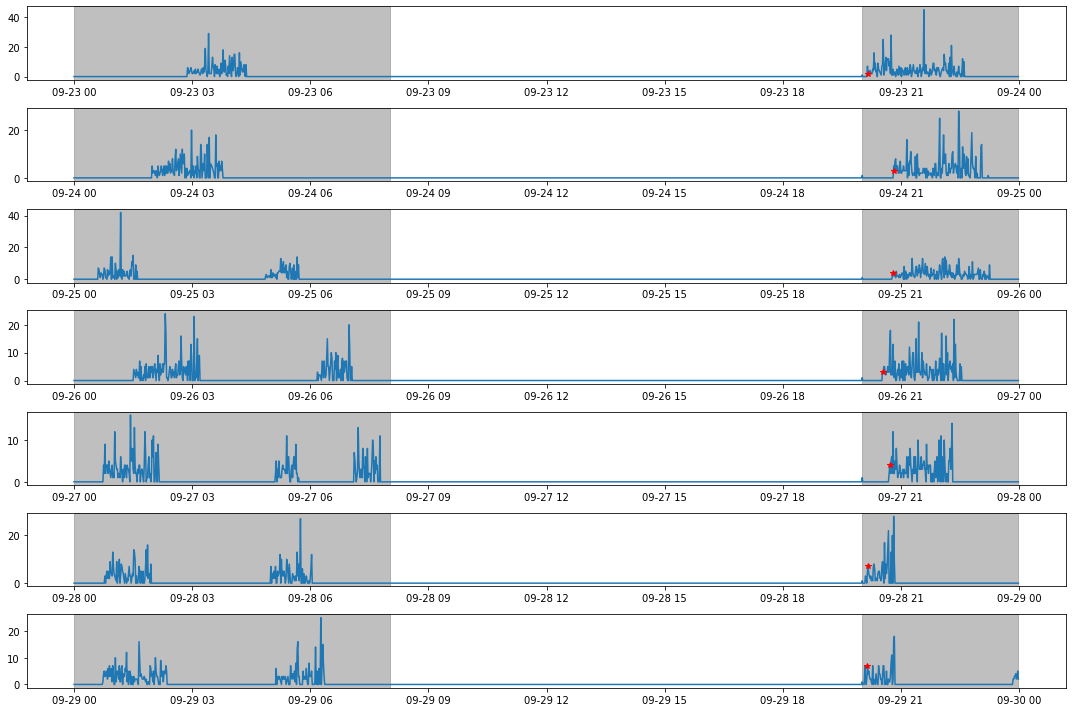

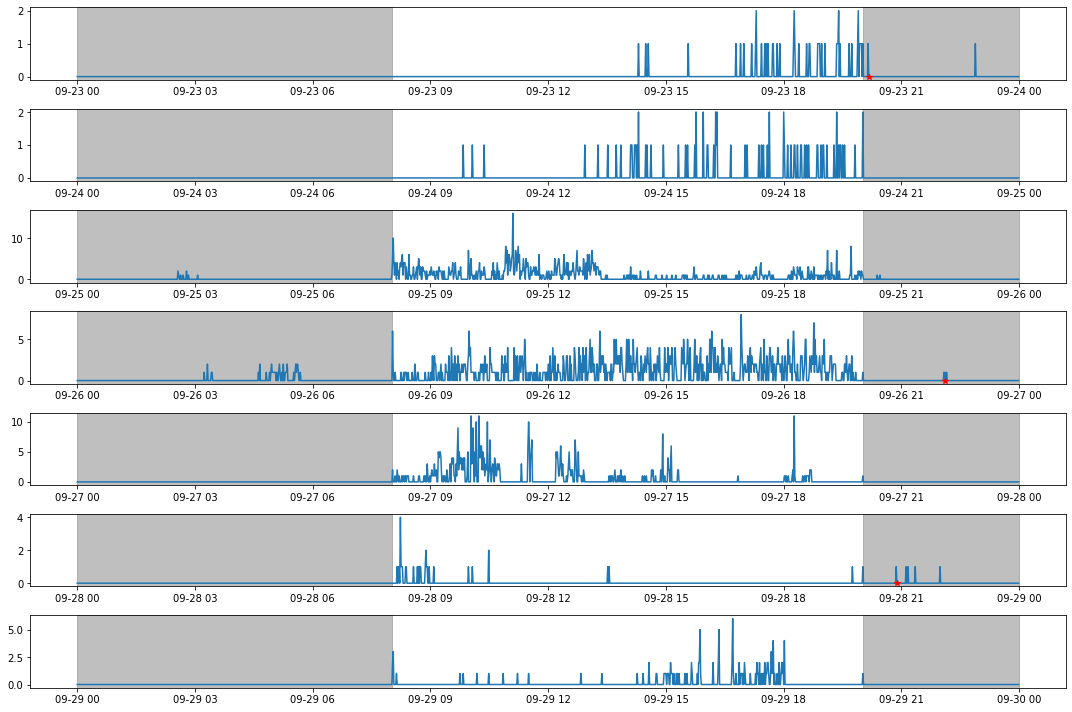

In [15]:
for spider in entrained.index:
    Filename = str(spider)+'_onset.png'
    plotonespider(spider,Filename)

### Periodogram Visual Inspection

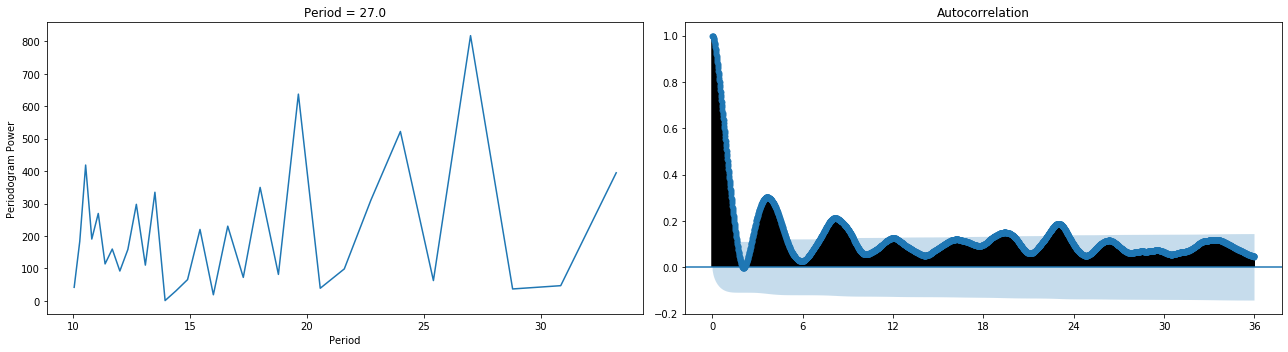

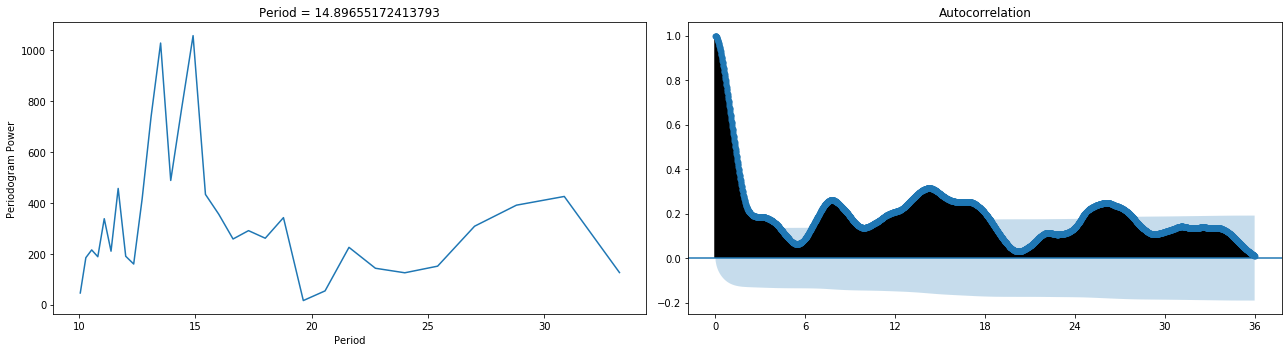

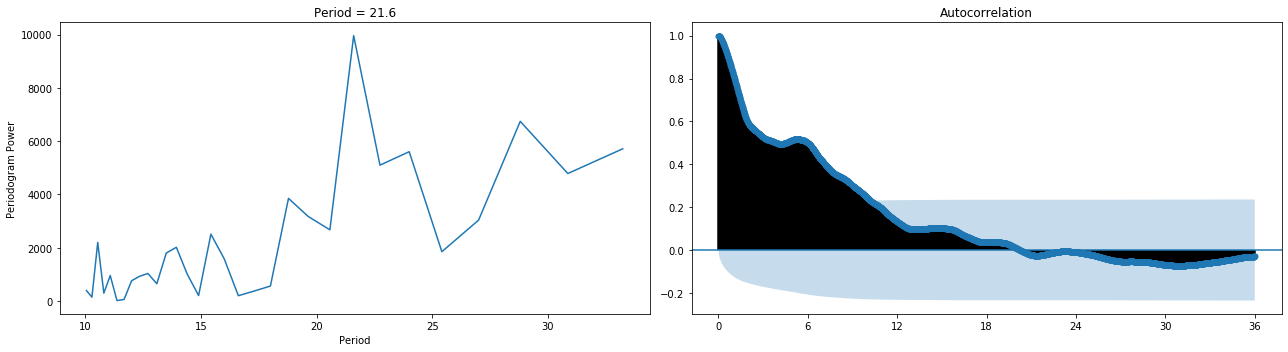

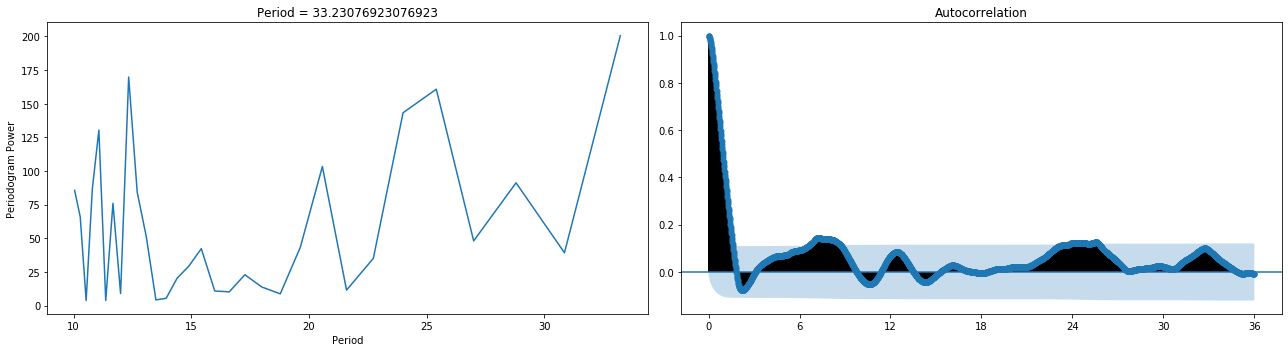

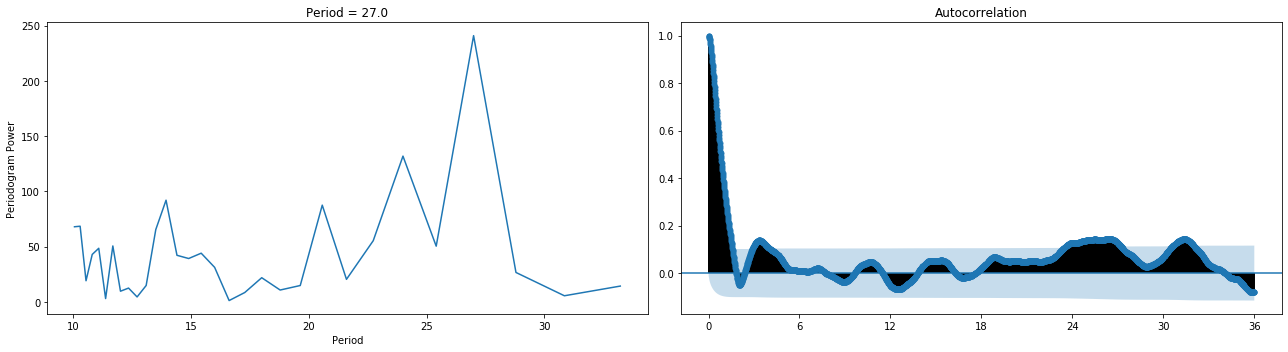

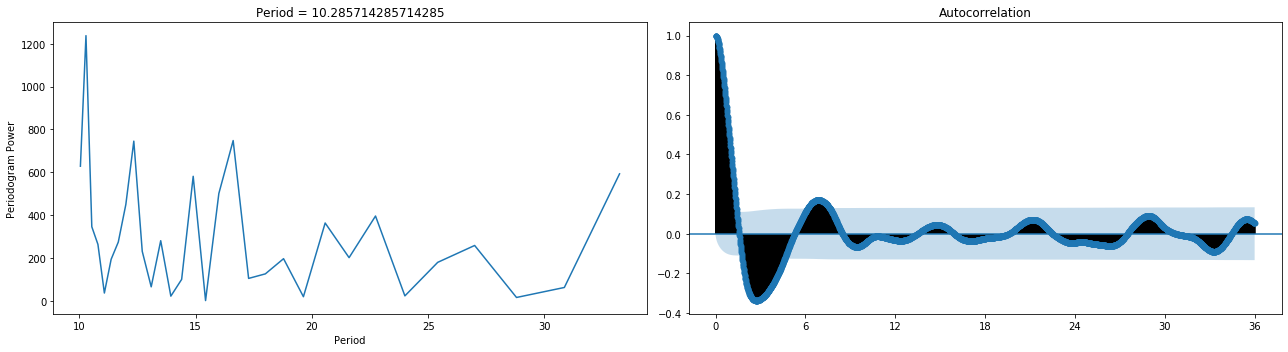

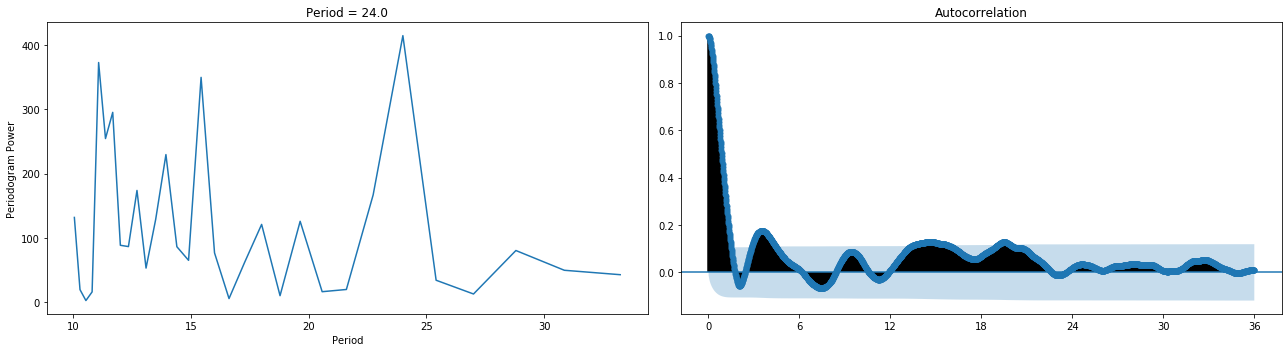

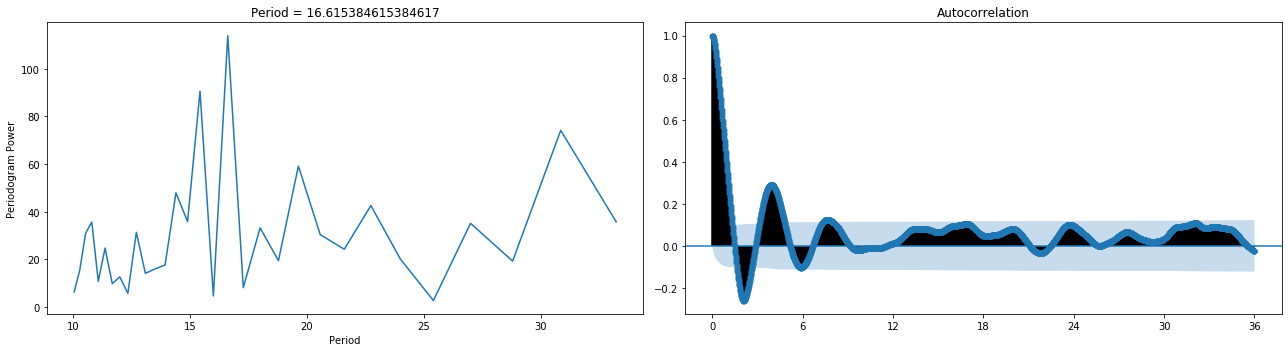

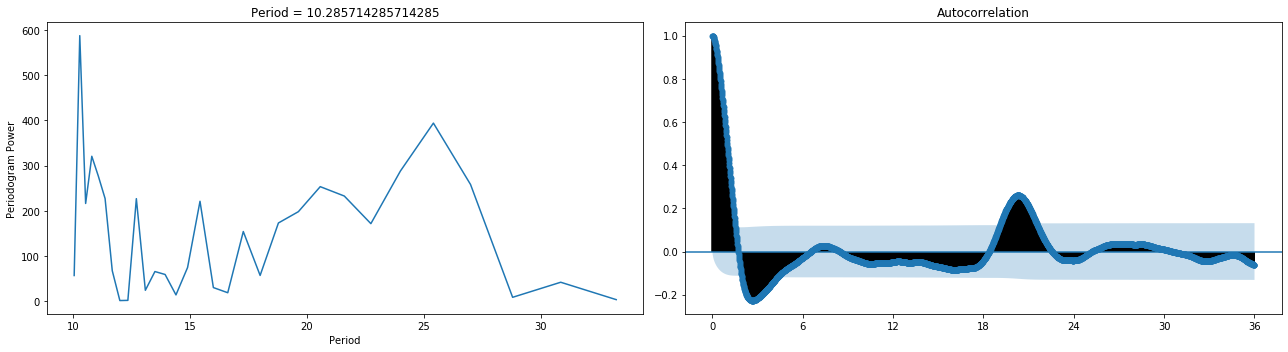

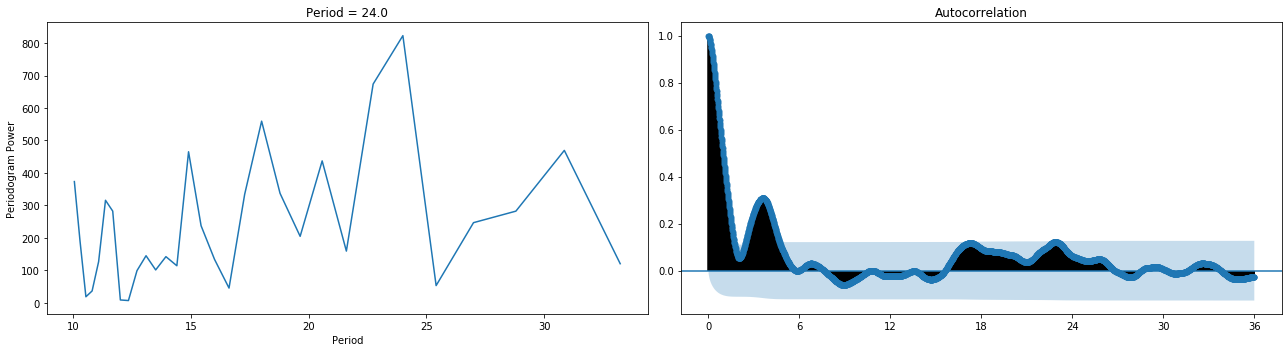

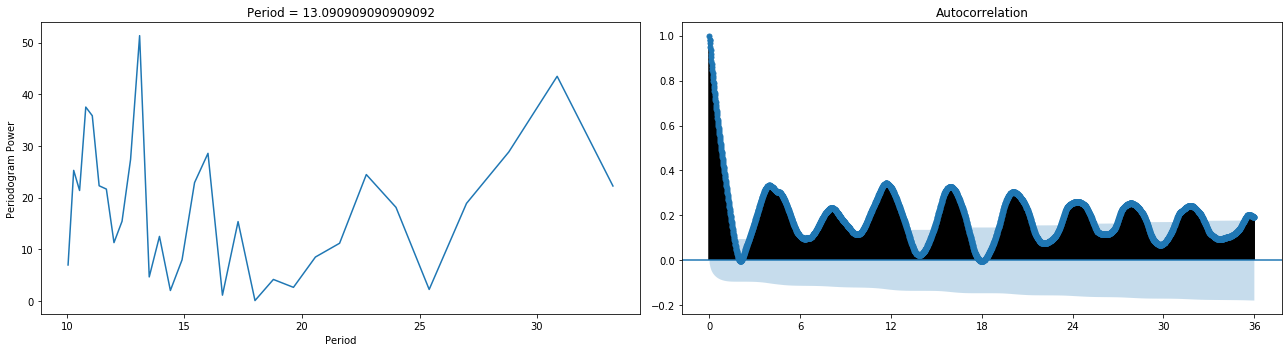

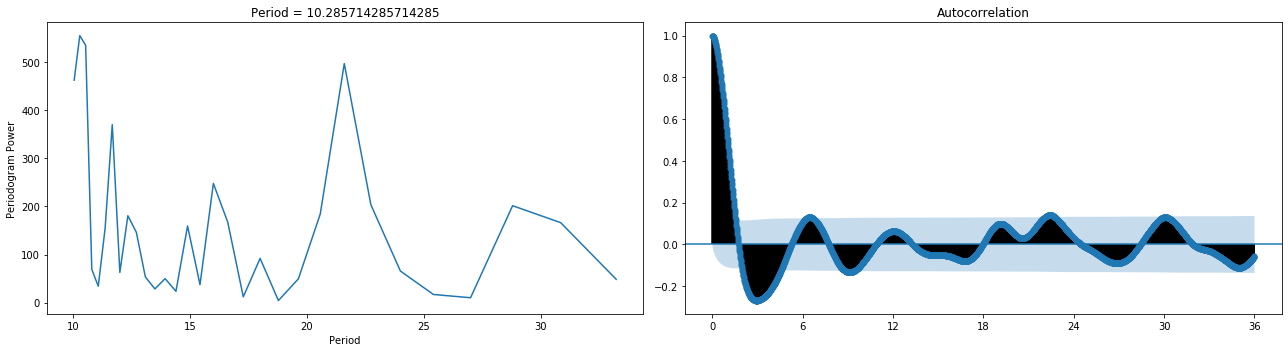

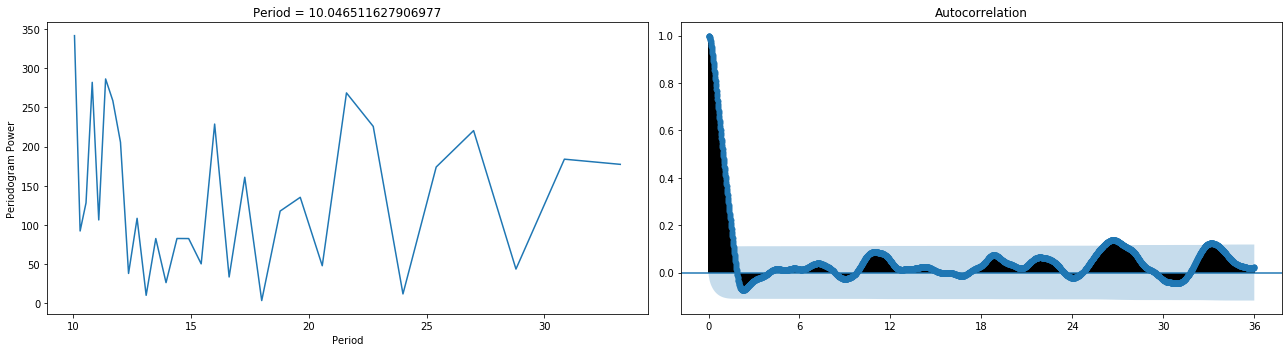

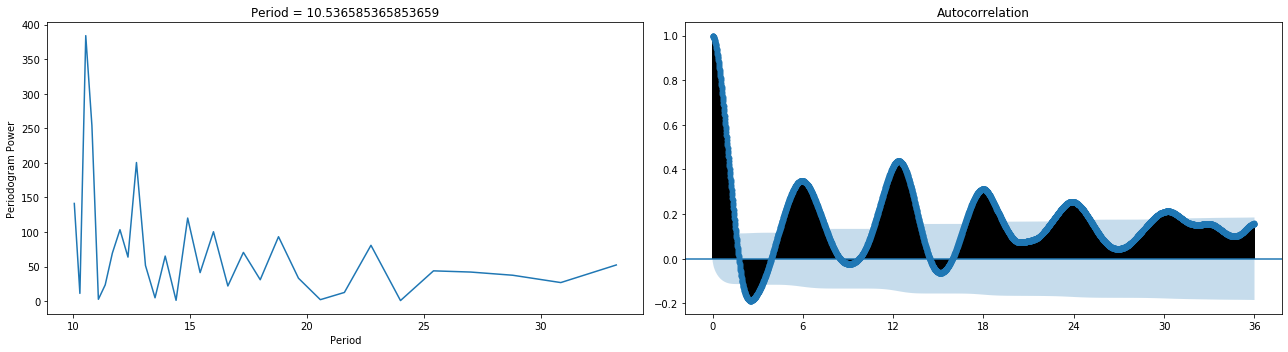

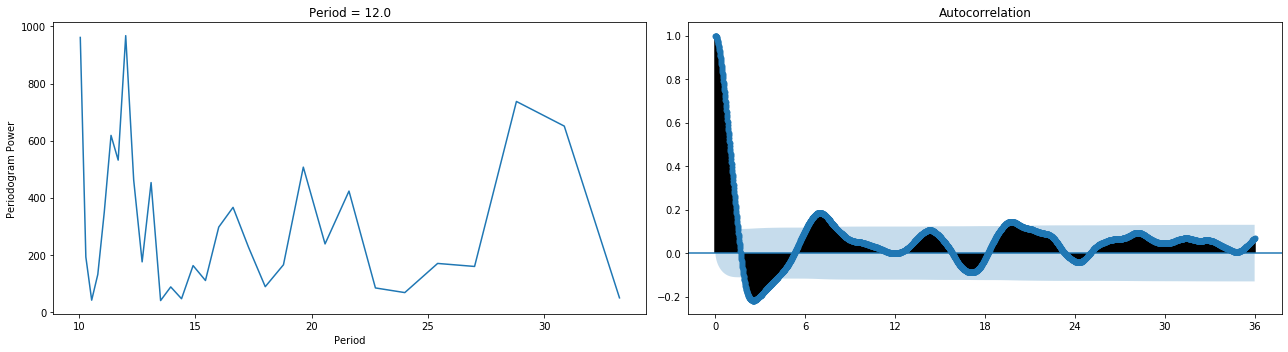

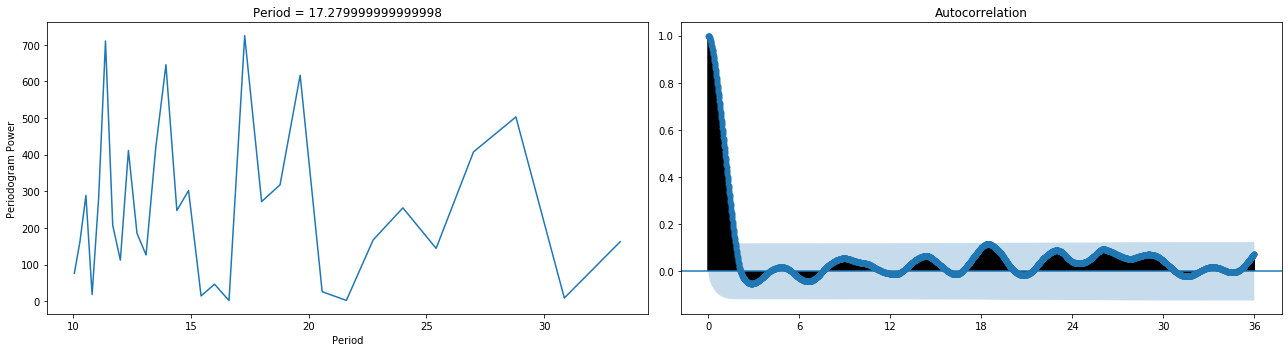

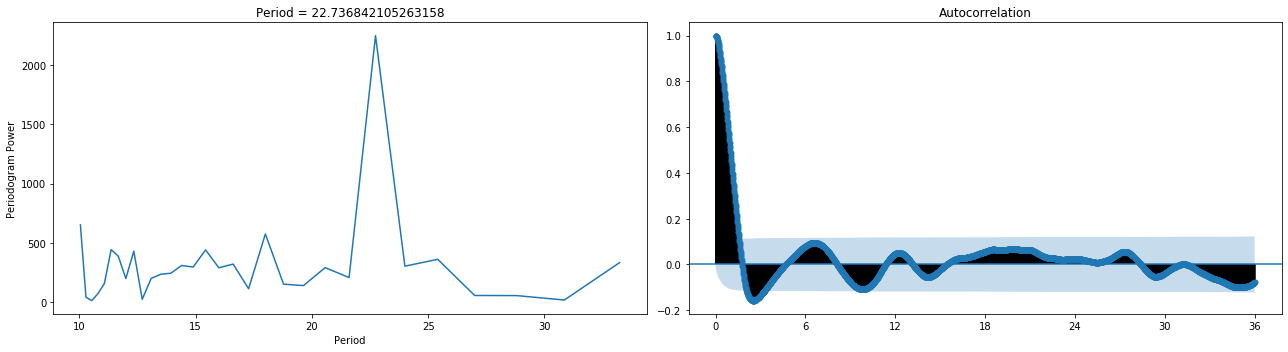

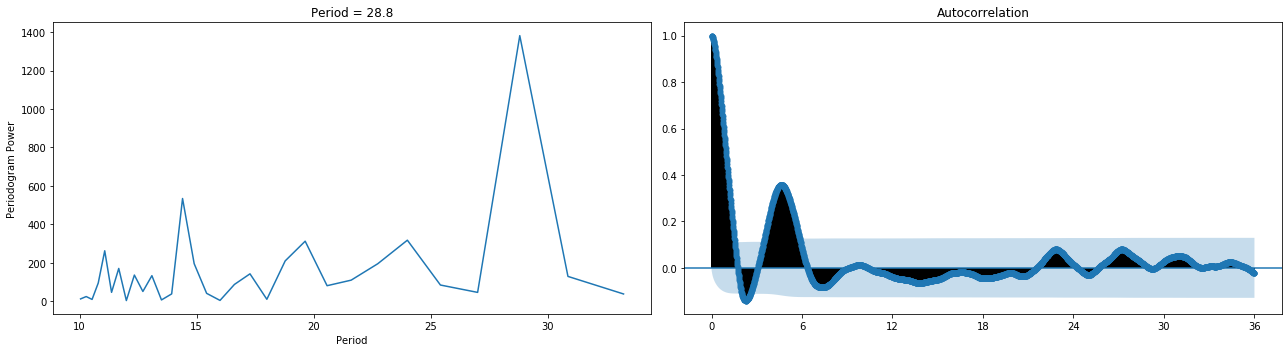

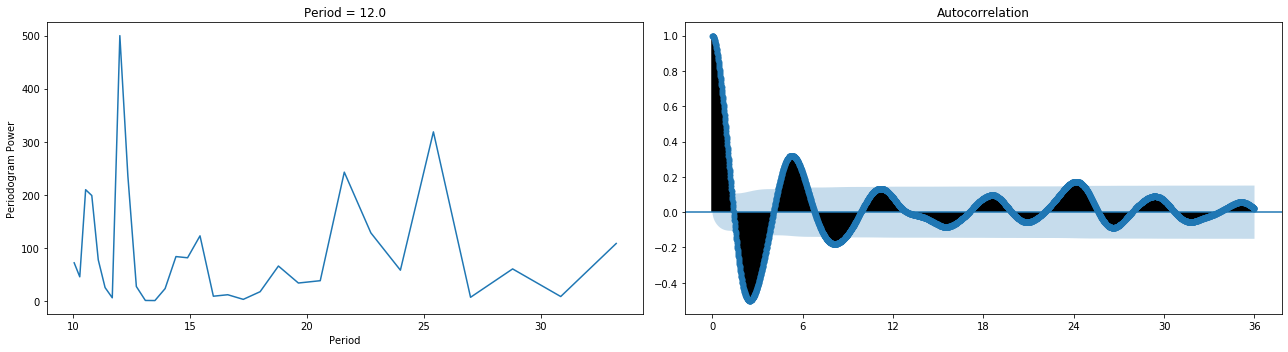

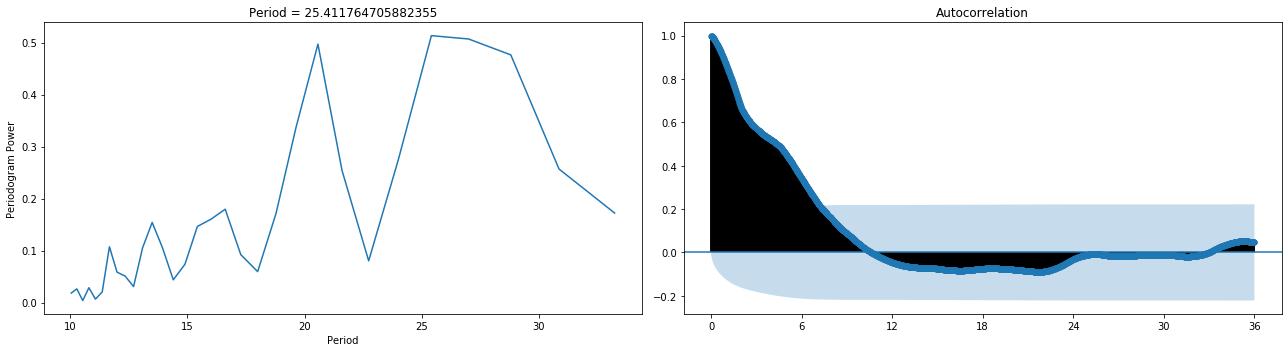

In [20]:
for spider in entrained.index:
    file_name='pgram_acf_'+str(spider)+'.png'
    Plot_pgram(DD, spider, file_name)


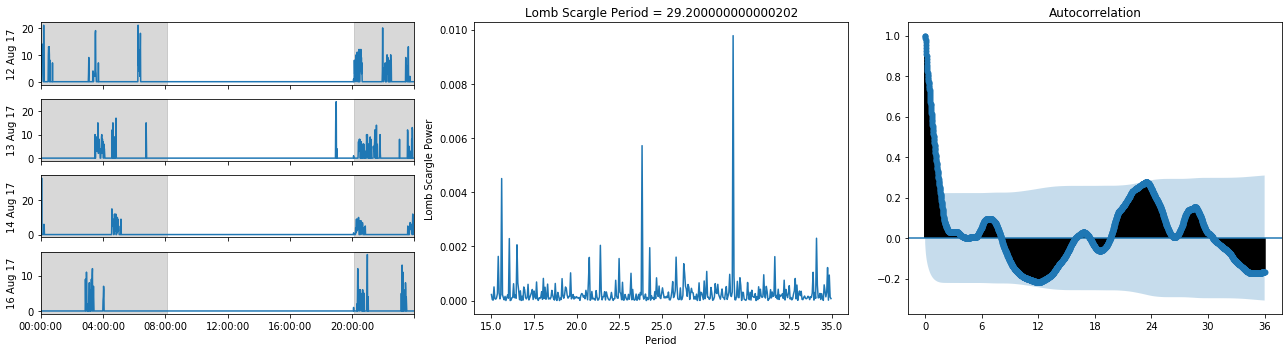

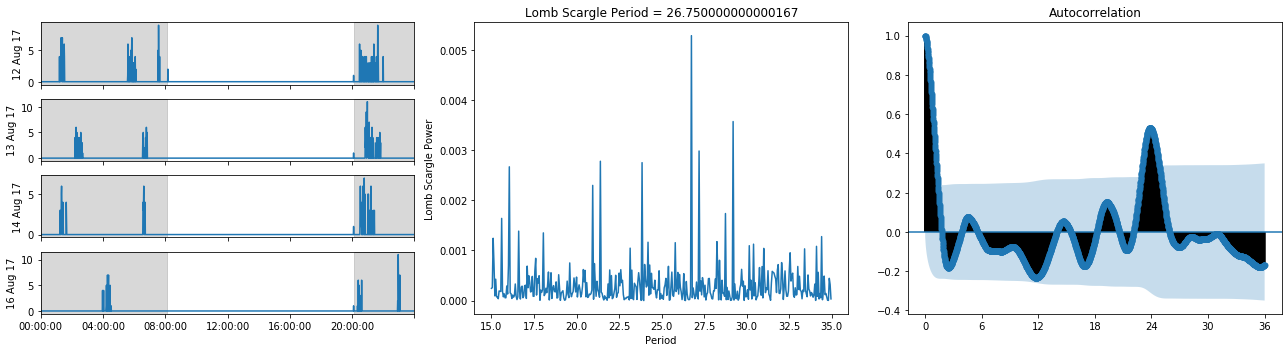

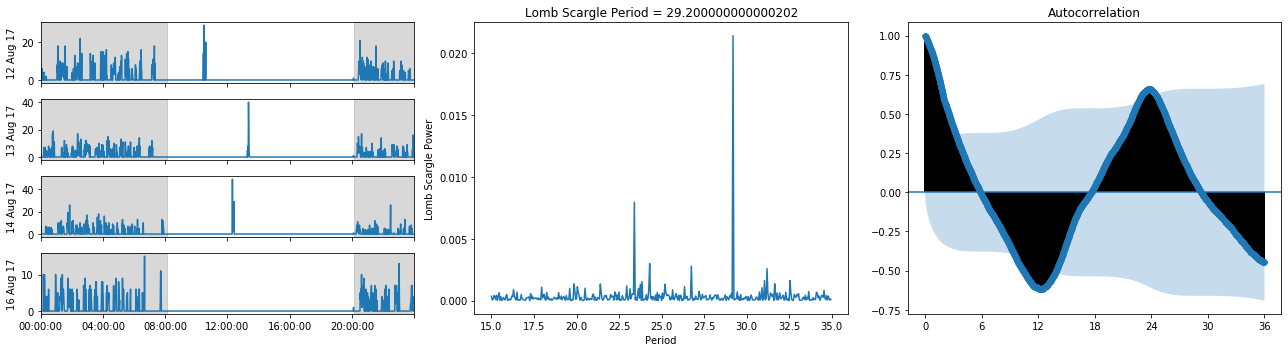

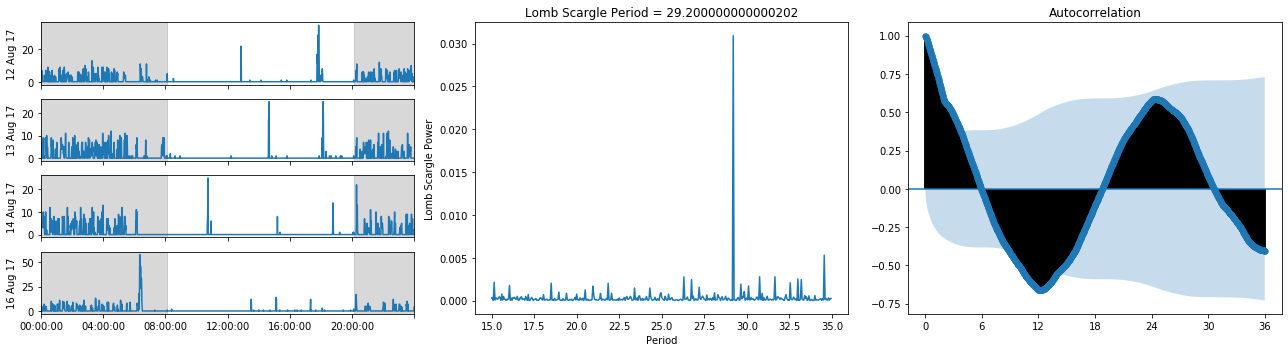

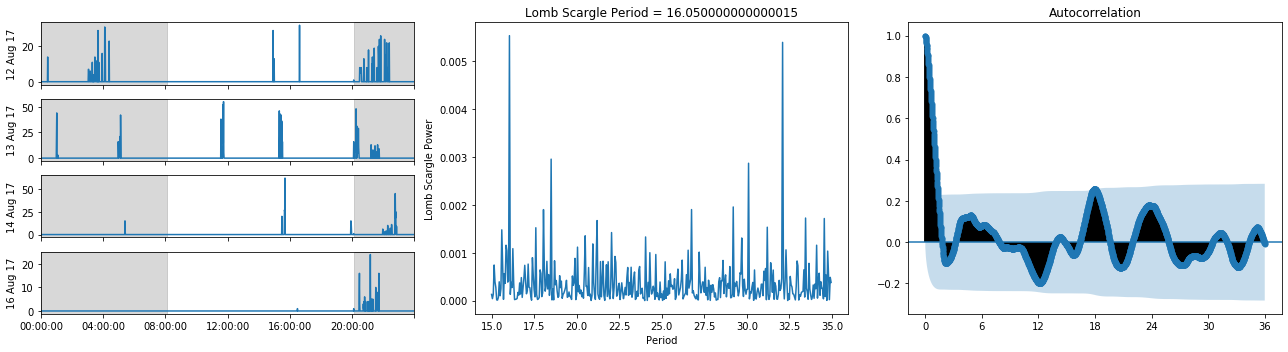

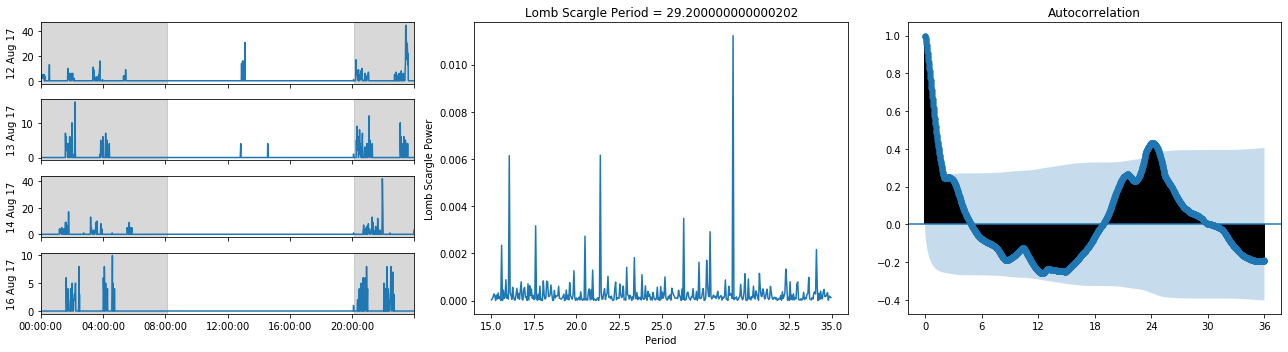

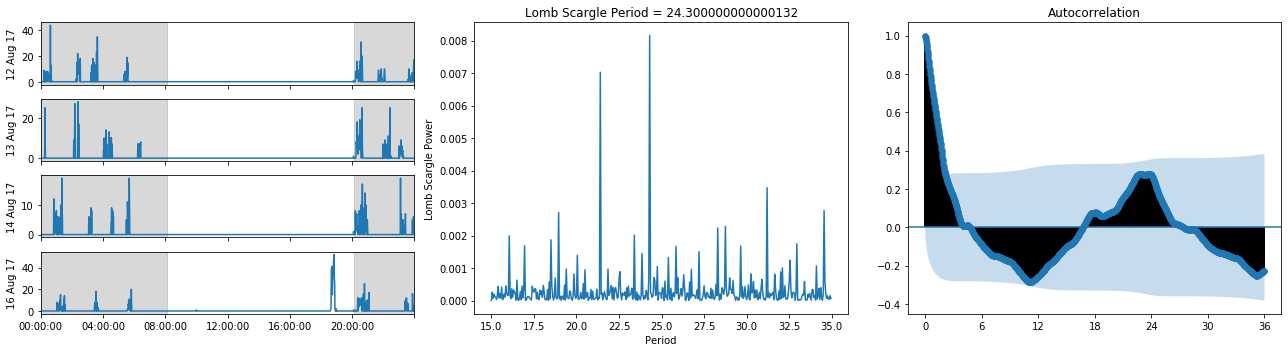

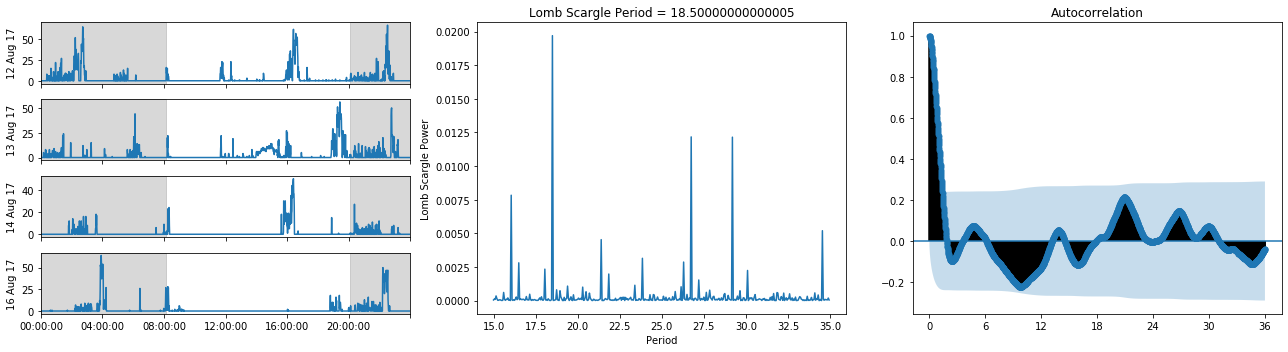

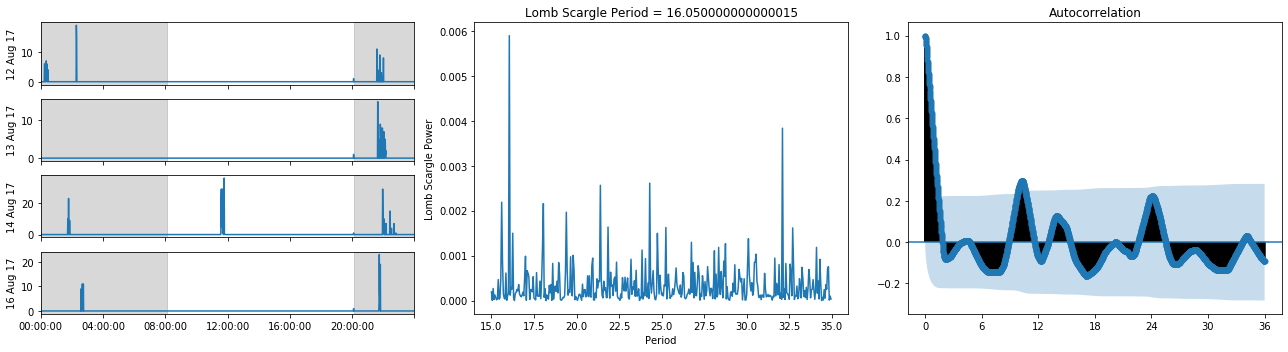

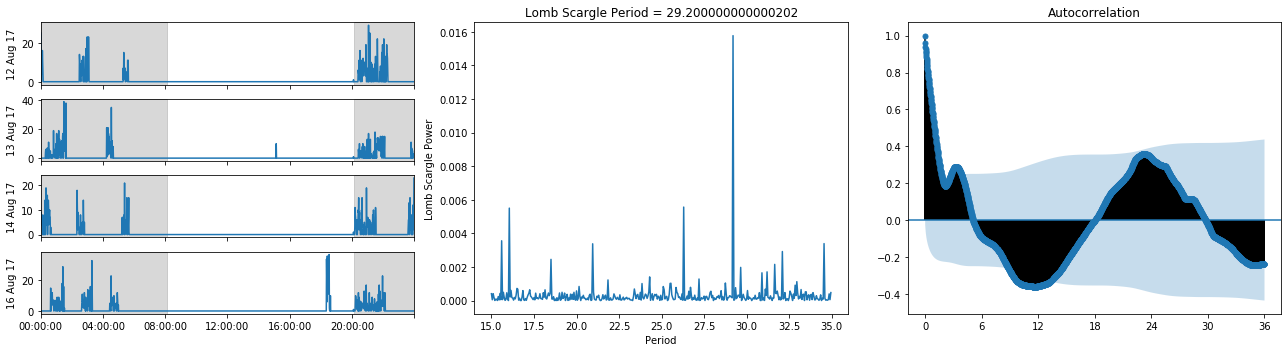

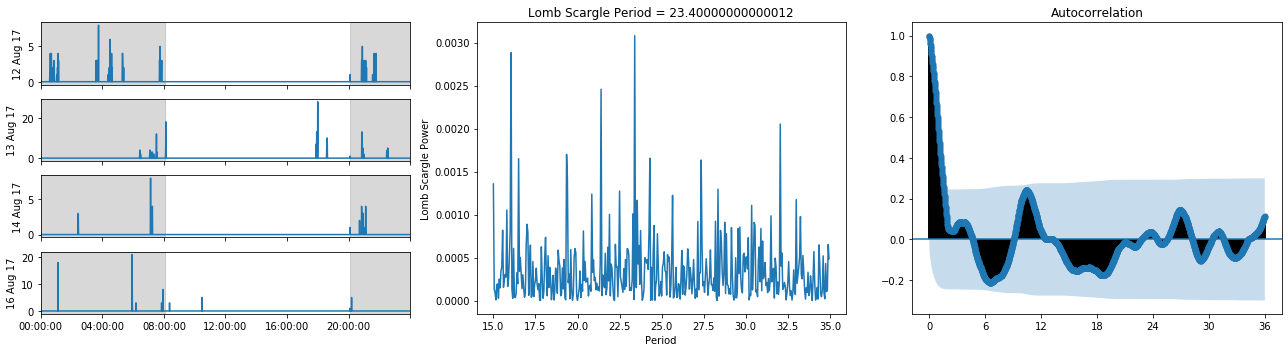

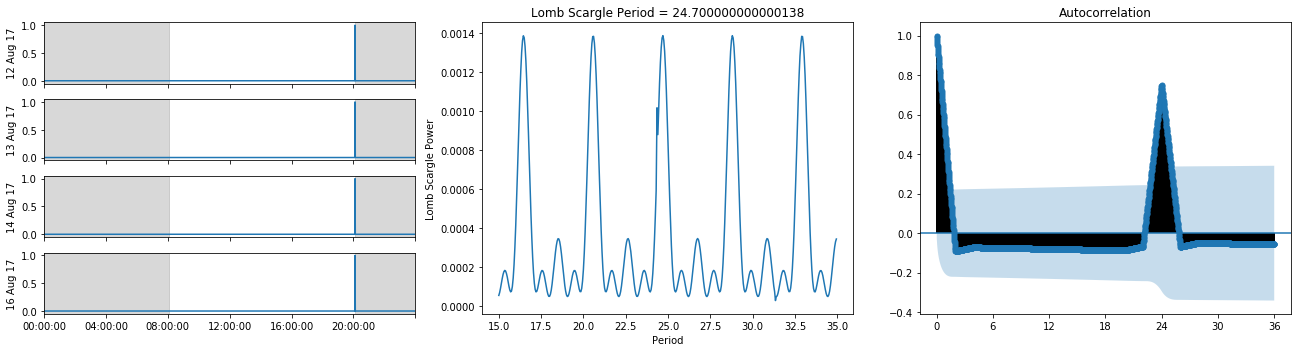

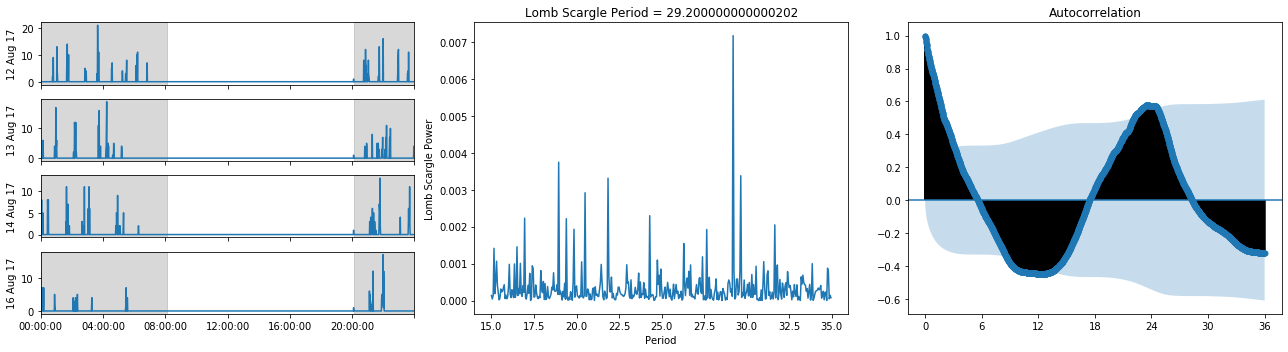

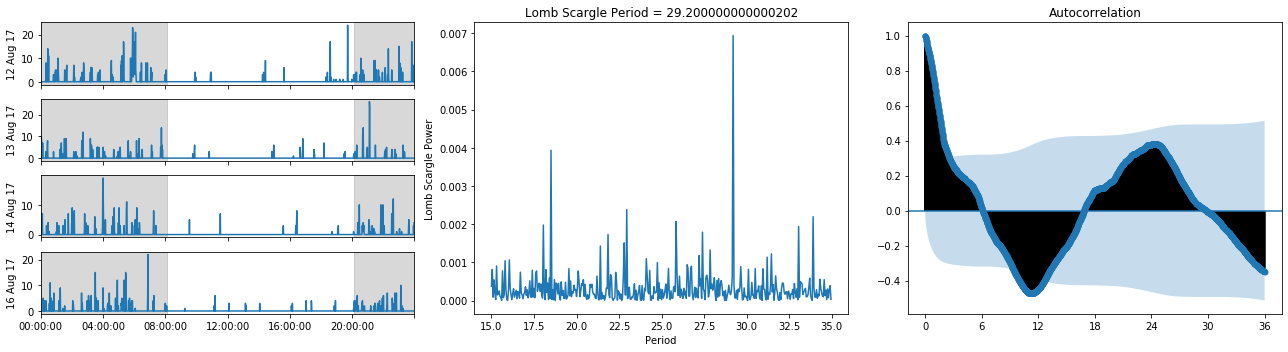

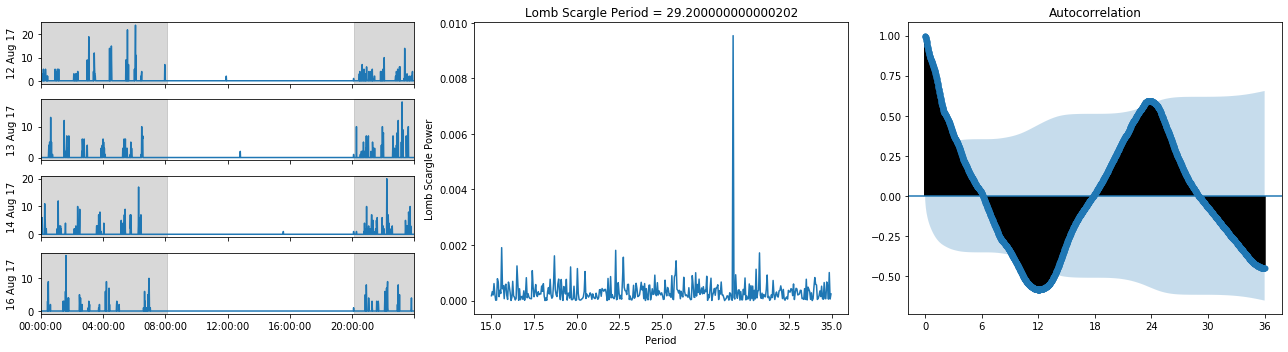

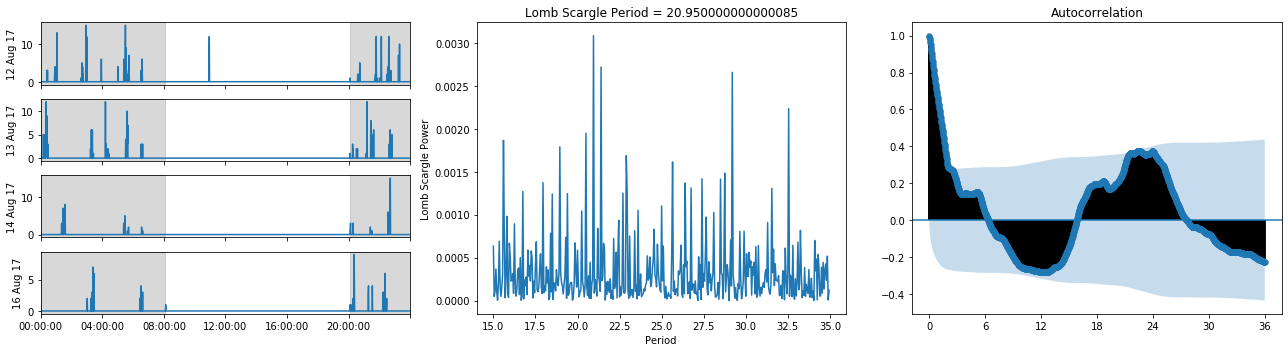

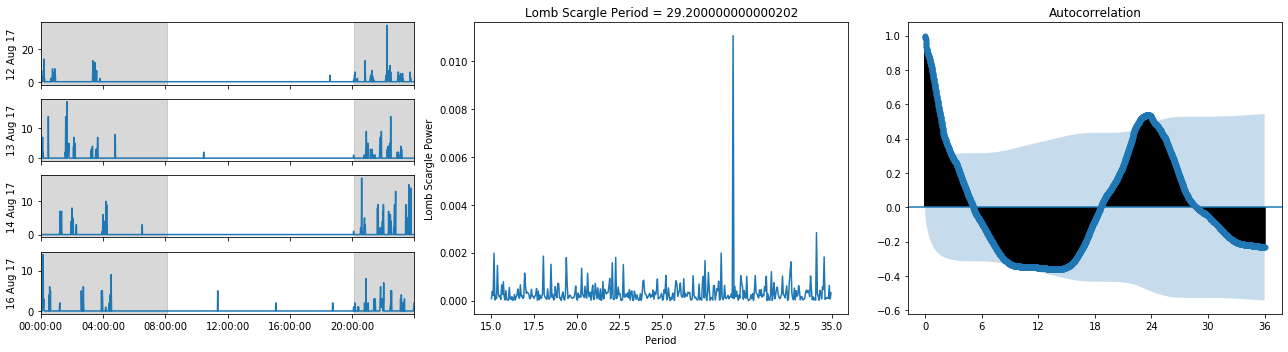

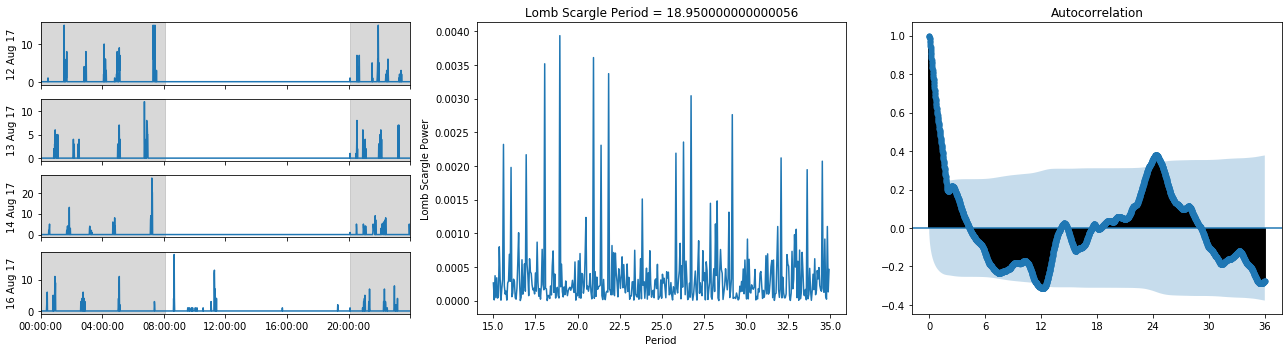

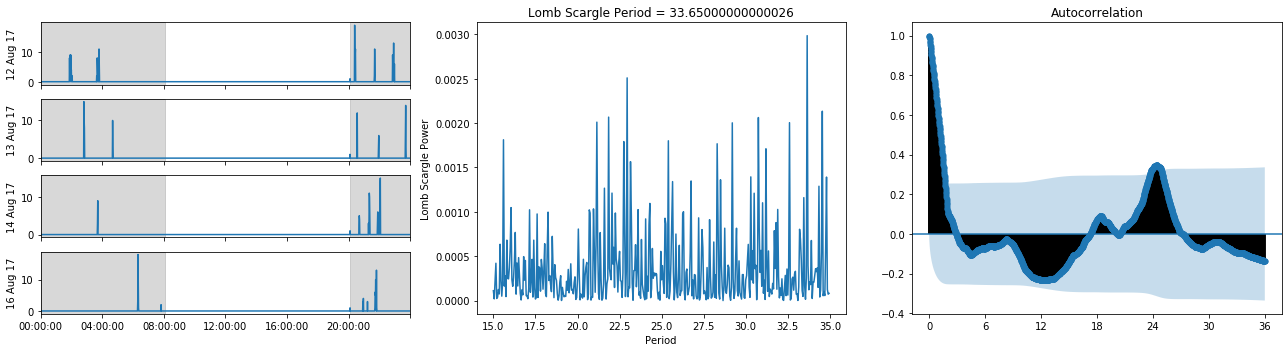

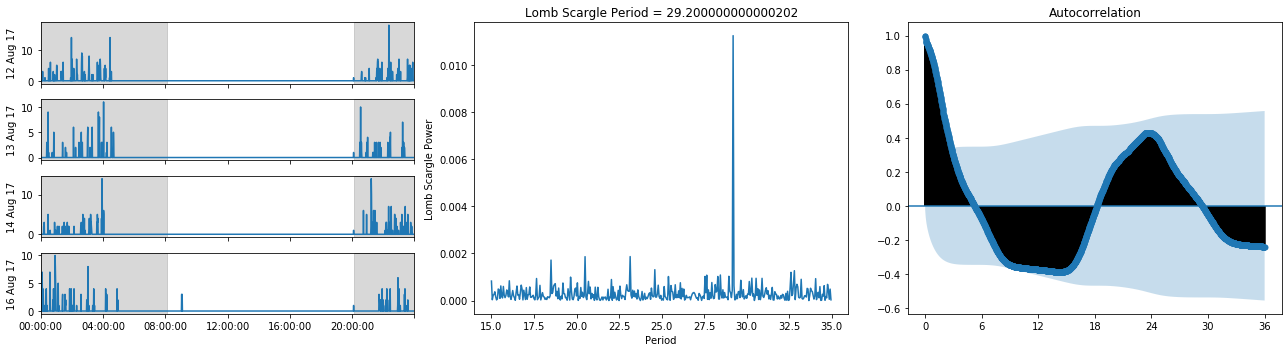

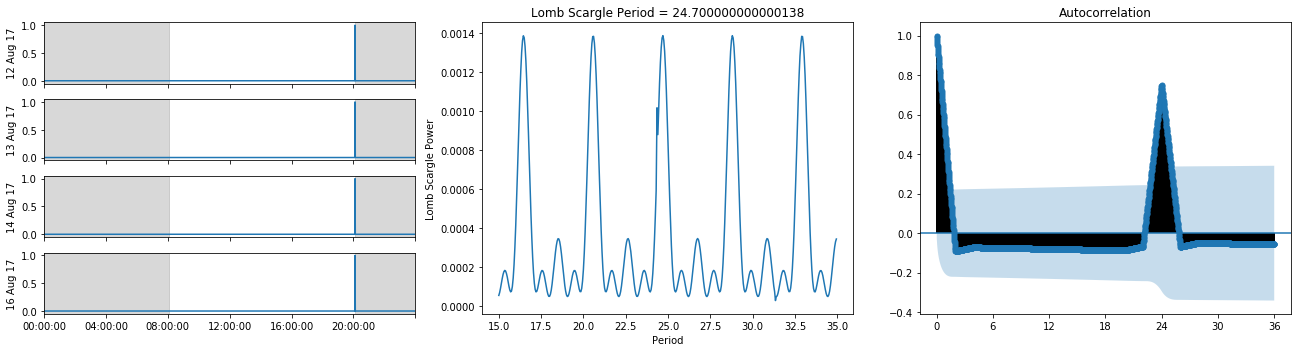

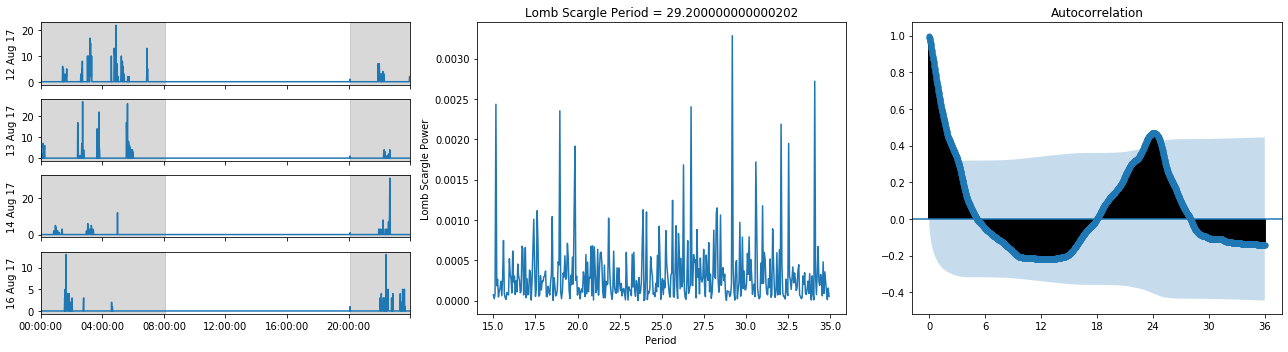

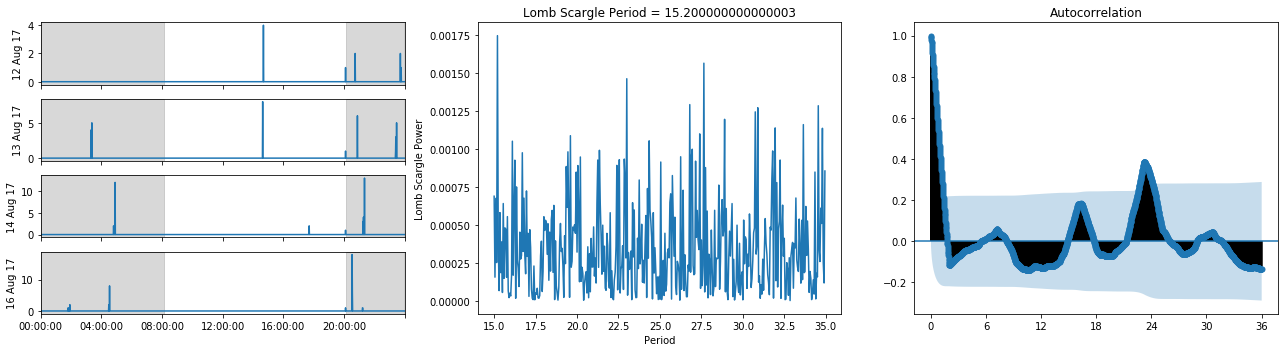

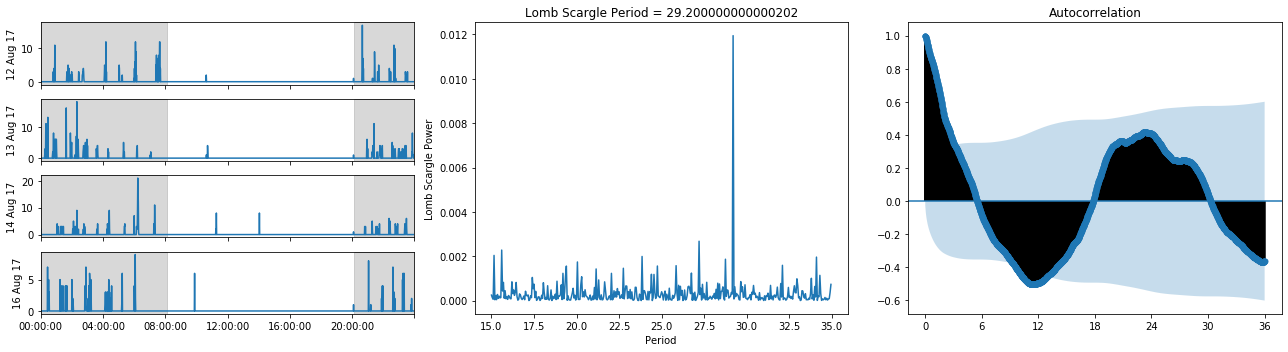

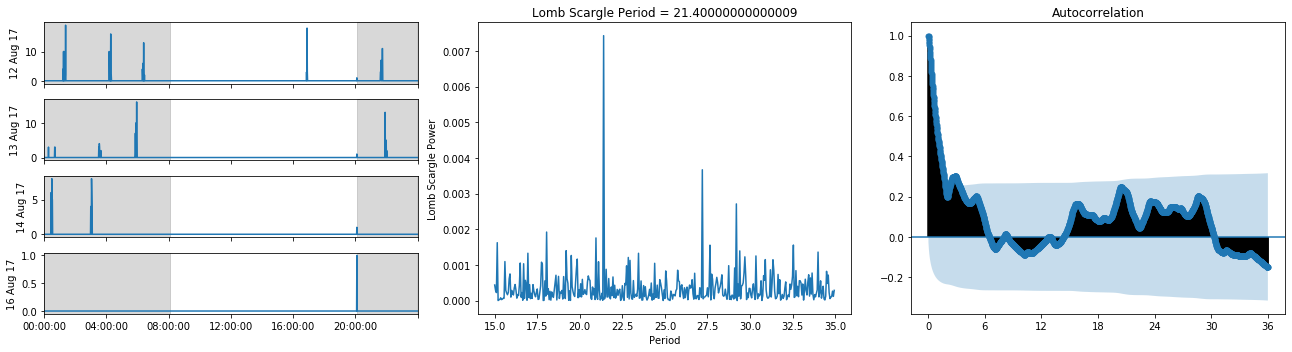

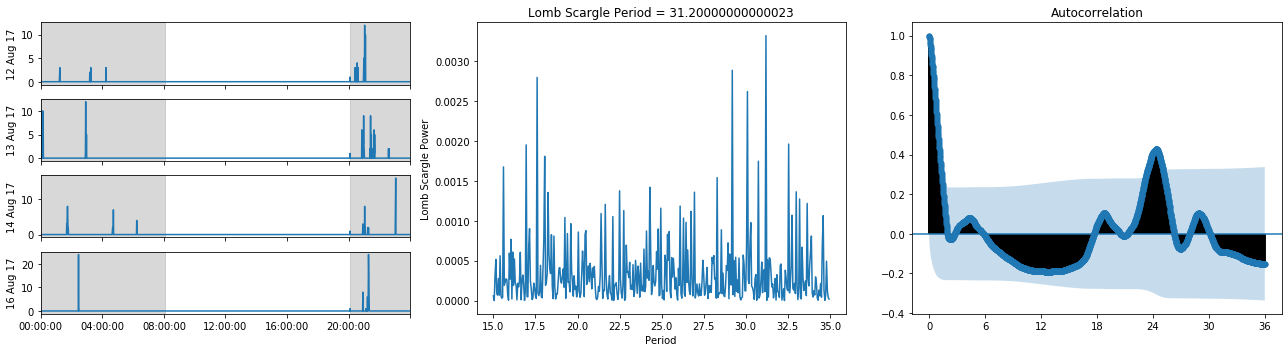

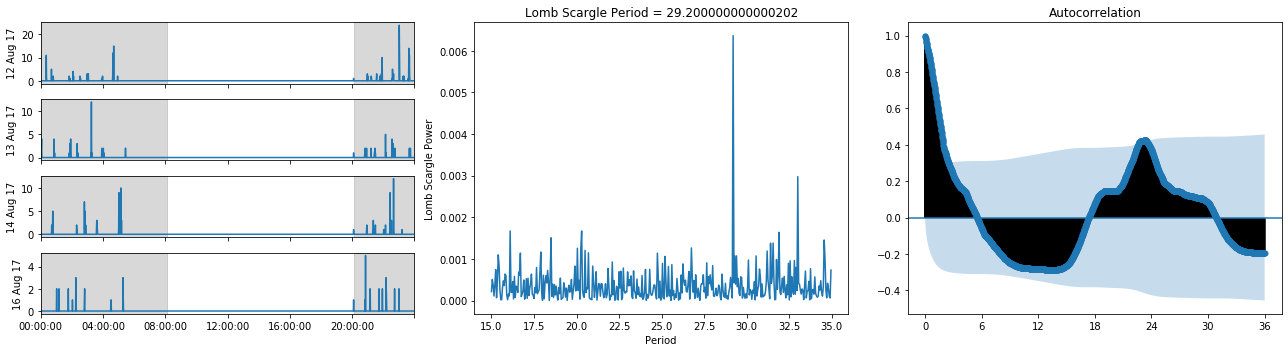

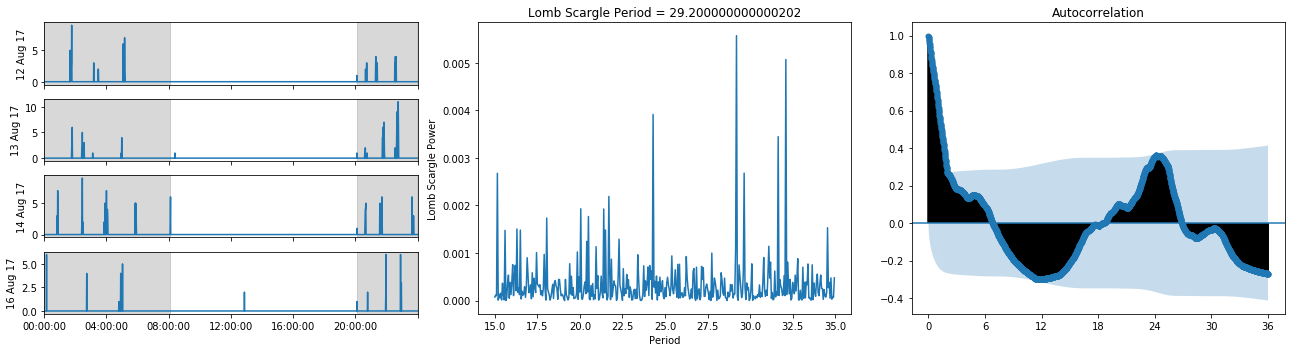

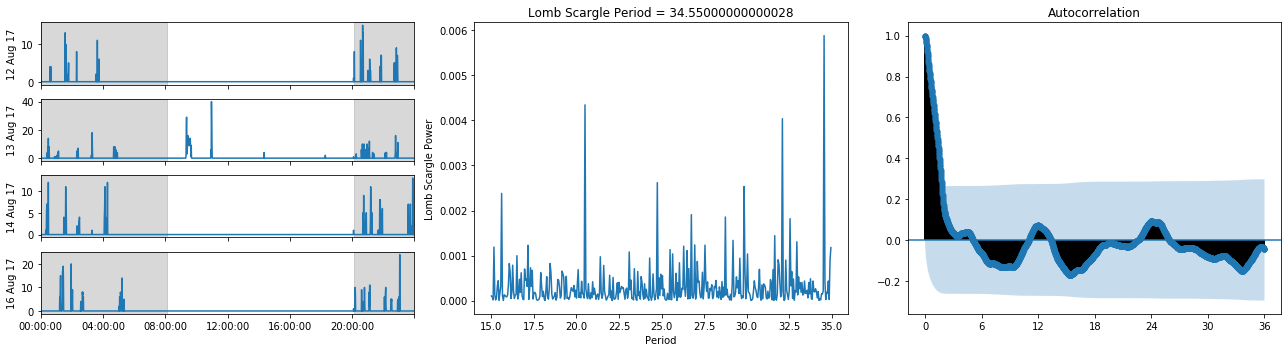

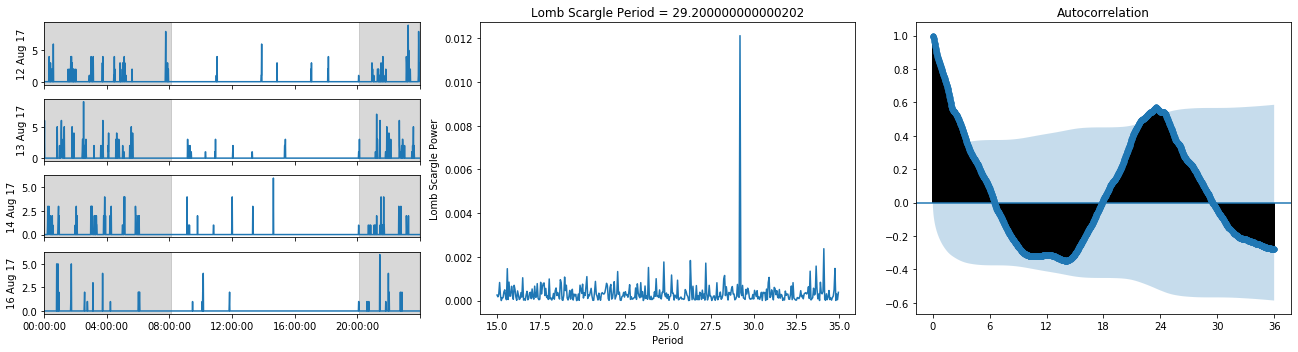

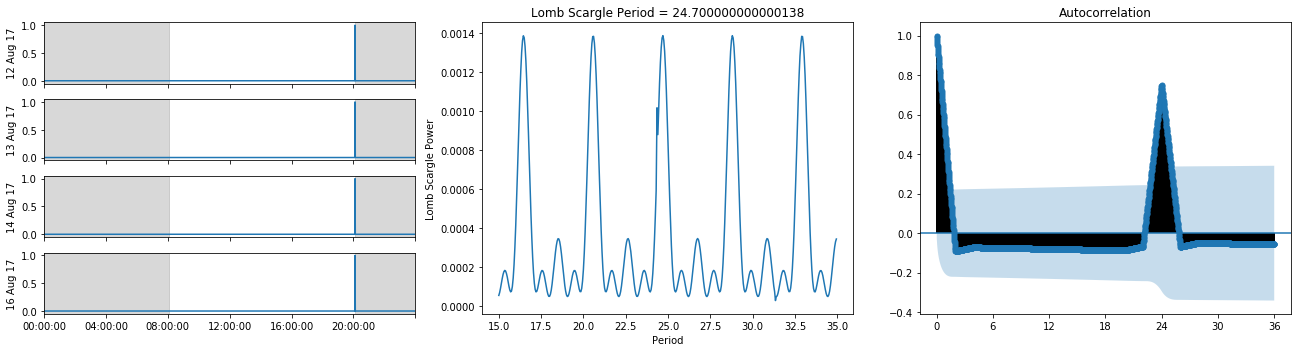

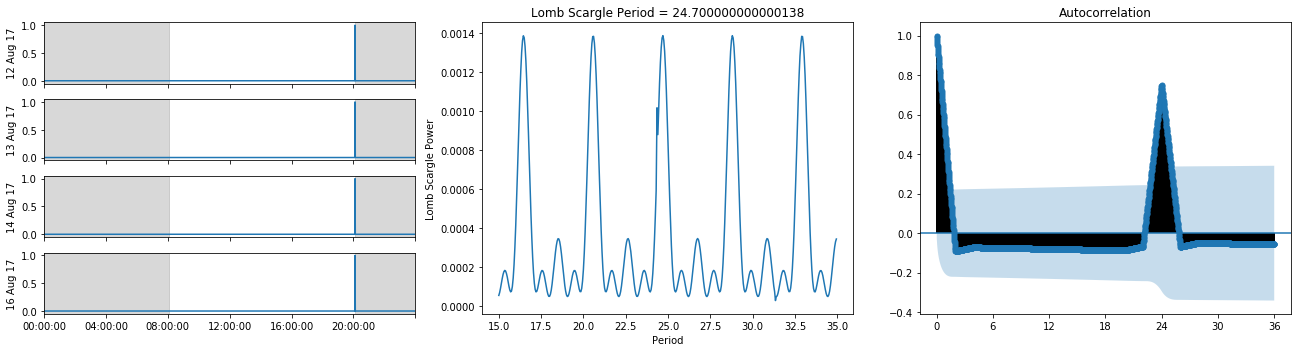

In [90]:
# Make the raster ls acf plot for each live spider 
for spider in LD.columns[3:].tolist():
    file_name='Rasters_LS_acf_'+str(spider)+'.png'
    Plot_Raster_LS(LD, spider,file_name)

13.5


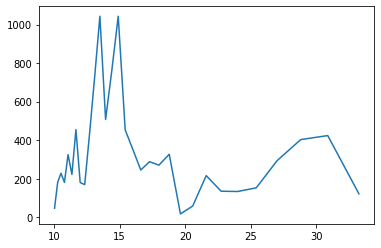

In [23]:
from statsmodels.tsa.stattools import periodogram
# calculate periodogram using stattools function
pgram = periodogram(DD.s2)

# create dataframe with power and period to we can plot and find max later
LS = pd.DataFrame(index = range(len(pgram)))
LS['Power'] = pgram
LS['Period'] = len(pgram)/LS.index /60

LS = LS[(LS.Period > 10) & (LS.Period < 35)]
# plot periodogram and only the part of interest
plt.plot(LS.Period, LS.Power)
#plt.xlim(0, 50)

Period = LS.Period[LS.Power == np.max(LS.Power)].iloc[0]
print(Period)
